In [1]:
from scipy import stats
import pandas as pd
import pandas_datareader as web
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model
%matplotlib inline

# Trading Algo explained

In [2]:
start = datetime(2016,1,1)
end = datetime(2021,12,1)

In [3]:
df_jpm = yf.download('PTN',start ,end)
# df_jpm['Close'] = df_jpm['Adj Close']
df_jpm = df_jpm.drop("Adj Close",axis=1)
df_jpm.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2016-01-04,0.6875,0.6875,0.640,0.6800,137836
2016-01-05,0.6700,0.6800,0.640,0.6600,127412
2016-01-06,0.6500,0.6790,0.650,0.6632,148428
2016-01-07,0.6790,0.6790,0.621,0.6500,447891
2016-01-08,0.6500,0.6500,0.622,0.6220,176480


In [4]:
for sma_period in [5,10,20,50,100,200]:
    indicator_name = "SMA_%d" % (sma_period)
    df_jpm[indicator_name] = df_jpm['Close'].rolling(sma_period).mean()

In [5]:
df_jpm['BollingerBand_Up_20_2'] = df_jpm['Close'].rolling(20).mean() + 2*df_jpm['Close'].rolling(20).std()
df_jpm['BollingerBand_Down_20_2'] = df_jpm['Close'].rolling(20).mean() - 2*df_jpm['Close'].rolling(20).std()

df_jpm['BollingerBand_Up_10_1'] = df_jpm['Close'].rolling(10).mean() + df_jpm['Close'].rolling(10).std()
df_jpm['BollingerBand_Down_10_1'] = df_jpm['Close'].rolling(10).mean() - df_jpm['Close'].rolling(10).std()

In [6]:
# df_jpm = df_jpm.drop(['High','Low',], axis=1)

In [7]:
newdata = df_jpm[['Close','Open']]

In [8]:
for lag in [1,2,3,4,5,6,7,8,9,10]:
    shift = lag
    shifted = df_jpm.shift(shift)
    shifted.columns = [str.format("%s_shifted_by_%d" % (column ,shift)) for column in shifted.columns]
    newdata = pd.concat((newdata,shifted),axis=1)

In [9]:
forward_lag = 1
newdata['target'] = newdata['Close'].shift(-forward_lag)
#Dropped close
newdata = newdata.drop('Close',axis=1)
newdata.dropna()

,Open,Open_shifted_by_1,High_shifted_by_1,Low_shifted_by_1,Close_shifted_by_1,Volume_shifted_by_1,SMA_5_shifted_by_1,SMA_10_shifted_by_1,SMA_20_shifted_by_1,SMA_50_shifted_by_1,...,SMA_10_shifted_by_10,SMA_20_shifted_by_10,SMA_50_shifted_by_10,SMA_100_shifted_by_10,SMA_200_shifted_by_10,BollingerBand_Up_20_2_shifted_by_10,BollingerBand_Down_20_2_shifted_by_10,BollingerBand_Up_10_1_shifted_by_10,BollingerBand_Down_10_1_shifted_by_10,target
Date,,,,,,,,,,,,,,,,,,,,,
2016-10-31,0.5150,0.5100,0.5199,0.5000,0.5045,630089.0,0.51744,0.53891,0.563300,0.553500,...,0.58520,0.592030,0.555632,0.545337,0.532718,0.649911,0.534149,0.600833,0.569567,0.4842
2016-11-01,0.5200,0.5150,0.5200,0.4802,0.5200,867485.0,0.51338,0.53266,0.558930,0.553544,...,0.58610,0.595270,0.556130,0.545987,0.532293,0.645300,0.545240,0.602040,0.570160,0.5700
2016-11-02,0.7500,0.5200,0.5200,0.4800,0.4842,6323999.0,0.50822,0.52158,0.553840,0.552628,...,0.58270,0.594820,0.555330,0.546065,0.531698,0.646693,0.542947,0.603997,0.561403,0.5220
2016-11-03,0.5990,0.7500,0.7500,0.5029,0.5700,30747757.0,0.51894,0.52448,0.553590,0.553436,...,0.57970,0.591820,0.554592,0.546212,0.531082,0.649090,0.534550,0.604765,0.554635,0.5049
2016-11-04,0.5200,0.5990,0.6000,0.5120,0.5220,4757318.0,0.52014,0.52268,0.551190,0.553376,...,0.57831,0.586390,0.554256,0.546346,0.530549,0.640120,0.532660,0.605082,0.551538,0.5100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-22,0.3750,0.3700,0.3782,0.3601,0.3601,1347265.0,0.37854,0.39266,0.404230,0.426666,...,0.41611,0.419545,0.443866,0.485082,0.595610,0.434567,0.404523,0.421274,0.410946,0.3444
2021-11-23,0.3546,0.3750,0.3750,0.3500,0.3540,1500601.0,0.36980,0.38672,0.401415,0.424198,...,0.41495,0.419165,0.442476,0.483317,0.592662,0.434716,0.403614,0.419918,0.409982,0.5144
2021-11-24,0.5300,0.3546,0.3580,0.3300,0.3444,1591835.0,0.36168,0.38011,0.397530,0.422020,...,0.41376,0.417745,0.441000,0.481903,0.590308,0.432529,0.402961,0.419284,0.408236,0.5576


In [10]:
from sklearn.model_selection import train_test_split

training_data  = newdata.head(len(newdata)-100)
training_data = training_data.dropna()
X = training_data.drop("target",axis=1)
Y = training_data['target']

import numpy as np
correlations = np.abs(X.corrwith(Y))
features =  list(correlations.sort_values(ascending=False)[0:50].index)
features.append('Open')
X = X[features]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomizedSearchCV(RandomForestRegressor(),
param_distributions =  {
                  'n_estimators':np.arange(10,500,10),
                  'max_features':np.arange(1,25,1)
               },
                  cv=5, n_iter = 20,
                  iid=False,random_state=0,refit=True,
                  scoring="neg_mean_absolute_error")
rf.fit(X_train,y_train)

print(rf.best_params_)

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'n_estimators': 320, 'max_features': 11}


In [13]:
model = RandomForestRegressor(n_estimators=rf.best_params_['n_estimators'], max_features=rf.best_params_['max_features'])
model.fit(X_train, y_train)

RandomForestRegressor(max_features=11, n_estimators=320)

In [14]:
y_pred = model.predict(X_test)

In [15]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,y_pred)

0.028584266364269254

In [16]:
def day_trade(real_open, pred_close, total, total_in_stocks,total_trades, signal):
    signal='H'
    if(real_open > pred_close and total_in_stocks>5000):
        #sell
        total_trades+=1
        total_in_stocks-=5000
        total += 5000*real_open
        signal="S"
        print('Sold %s shares at $%s totaling $%s'%(5000, round(real_open,2), round(5000*real_open,2)), signal)
        
    elif(total>5000 and real_open < pred_close):
        #buy
#         print("BUYING")
        total_trades+=1
        total_in_stocks+=5000/real_open
        total = total-5000
        signal="B"
        print('Bought %s shares at $%s totaling $%s'%(round(total_in_stocks,2), round(real_open,2), round((5000/real_open)*real_open,2)), signal)
        
    print(signal) 
    return total, total_in_stocks, total_trades, signal

In [17]:
df_jpm['Date'] = df_jpm.index
newdata['Date'] = newdata.index
total = 30000
total_in_stocks= 0
total_trades = 0
signal=''

#For DF

dates=[]
total_value=[]
stock_close=[]
stock_open=[]
pred_close=[]
target=[]
signals=[]

print('______________________________________')
for i in range(len(newdata)-100, len(newdata)-1):
    real_X = pd.DataFrame(columns=newdata[features].columns)
    real_X.loc[i] = newdata[features].iloc[i].values
    real_y = newdata.iloc[i]['target']
    pred_y = model.predict(real_X)
    real_open = newdata.iloc[i]['Open']
    #GARCH uptrend for 4 days buy, #GARCH downtrend for one day sell
    print('Date:',newdata['Date'].iloc[i])
    print("\nTOTAL(STOCKS+BP): ",round(total_in_stocks*real_open+ total,2)," Open: ", round(real_open,2), " P Close: ",round(pred_y[0],2) )
#     print('before', real_open ,pred_y,real_open>pred_y,total, total_in_stocks, total_trades )
    total, total_in_stocks, total_trades, signal = day_trade(real_open ,pred_y, total, total_in_stocks, total_trades, signal)
#     print(day_trade(real_open ,pred_y, total, total_in_stocks, total_trades, signal))
    #     print('after', real_open ,pred_y,total, total_in_stocks, total_trades)
    dates.append(newdata['Date'].iloc[i])
    total_value.append(total_in_stocks*real_open+total)
    stock_close.append(newdata.iloc[i+1]['target'])
    stock_open.append(real_open)
    pred_close.append(pred_y[0])
    target.append(real_y)
    print("SIGNAL ",signal)
    signals.append(signal)
    
    print('______________________________________')

______________________________________
Date: 2021-07-12 00:00:00

TOTAL(STOCKS+BP):  30000.0  Open:  0.59  P Close:  0.57
H
SIGNAL  H
______________________________________
Date: 2021-07-13 00:00:00

TOTAL(STOCKS+BP):  30000.0  Open:  0.56  P Close:  0.55
H
SIGNAL  H
______________________________________
Date: 2021-07-14 00:00:00

TOTAL(STOCKS+BP):  30000.0  Open:  0.57  P Close:  0.55
H
SIGNAL  H
______________________________________
Date: 2021-07-15 00:00:00

TOTAL(STOCKS+BP):  30000.0  Open:  0.56  P Close:  0.55
H
SIGNAL  H
______________________________________
Date: 2021-07-16 00:00:00

TOTAL(STOCKS+BP):  30000.0  Open:  0.54  P Close:  0.55
Bought 9259.26 shares at $0.54 totaling $5000.0 B
B
SIGNAL  B
______________________________________
Date: 2021-07-19 00:00:00

TOTAL(STOCKS+BP):  29916.67  Open:  0.53  P Close:  0.54
Bought 18675.45 shares at $0.53 totaling $5000.0 B
B
SIGNAL  B
______________________________________
Date: 2021-07-20 00:00:00

TOTAL(STOCKS+BP):  29711.24 

Date: 2021-09-24 00:00:00

TOTAL(STOCKS+BP):  27009.96  Open:  0.45  P Close:  0.45
Bought 43713.29 shares at $0.45 totaling $5000.0 B
B
SIGNAL  B
______________________________________
Date: 2021-09-27 00:00:00

TOTAL(STOCKS+BP):  27691.89  Open:  0.47  P Close:  0.46
Sold 5000 shares at $0.47 totaling $2330.0 S
S
SIGNAL  S
______________________________________
Date: 2021-09-28 00:00:00

TOTAL(STOCKS+BP):  28233.88  Open:  0.48  P Close:  0.47
Sold 5000 shares at $0.48 totaling $2400.0 S
S
SIGNAL  S
______________________________________
Date: 2021-09-29 00:00:00

TOTAL(STOCKS+BP):  27222.48  Open:  0.45  P Close:  0.47
Bought 44824.4 shares at $0.45 totaling $5000.0 B
B
SIGNAL  B
______________________________________
Date: 2021-09-30 00:00:00

TOTAL(STOCKS+BP):  26648.73  Open:  0.44  P Close:  0.44
Bought 56260.81 shares at $0.44 totaling $5000.0 B
B
SIGNAL  B
______________________________________
Date: 2021-10-01 00:00:00

TOTAL(STOCKS+BP):  26918.78  Open:  0.44  P Close:  0.44

In [18]:
plot_df=pd.DataFrame()
plot_df['Date'] = dates
plot_df['Total'] = total_value
plot_df['Open'] = stock_open
plot_df['Close'] = stock_close
plot_df['PClose'] = pred_close
plot_df['TClose'] = target
plot_df['Signal'] = signals

In [19]:
plot_df

,Date,Total,Open,Close,PClose,TClose,Signal
0,2021-07-12,30000.000000,0.5900,0.5559,0.572758,0.5611,H
1,2021-07-13,30000.000000,0.5600,0.5339,0.548303,0.5559,H
2,2021-07-14,30000.000000,0.5706,0.5300,0.553811,0.5339,H
3,2021-07-15,30000.000000,0.5557,0.5111,0.548036,0.5300,H
4,2021-07-16,30000.000000,0.5400,0.5237,0.546294,0.5111,B
...,...,...,...,...,...,...,...
94,2021-11-22,23608.198664,0.3750,0.5144,0.372517,0.3444,S
95,2021-11-23,22574.914864,0.3546,0.5576,0.367577,0.5144,H
96,2021-11-24,31459.132776,0.5300,0.8550,0.439692,0.5576,S
97,2021-11-26,28537.457039,0.4660,0.7149,0.478085,0.8550,B


In [20]:
plot_df['Buy&Hold'] =[0]*len(plot_df)
for i in range(1,len(plot_df)):
#     print(plot_df['TClose'].iloc[i-1],plot_df['Open'].iloc[0],plot_df['TClose'].iloc[i-1] - plot_df['Open'].iloc[0] )
    plot_df['Buy&Hold'].iloc[i] = 30000+30000*(plot_df['TClose'].iloc[i-1] - plot_df['Open'].iloc[0])

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [21]:
plot_df=plot_df[1:]
plot_df

,Date,Total,Open,Close,PClose,TClose,Signal,Buy&Hold
1,2021-07-13,30000.000000,0.5600,0.5339,0.548303,0.5559,H,29133.000970
2,2021-07-14,30000.000000,0.5706,0.5300,0.553811,0.5339,H,28977.000117
3,2021-07-15,30000.000000,0.5557,0.5111,0.548036,0.5300,H,28317.001462
4,2021-07-16,30000.000000,0.5400,0.5237,0.546294,0.5111,B,28199.999928
5,2021-07-19,29916.666639,0.5310,0.5352,0.542782,0.5237,B,27633.000612
...,...,...,...,...,...,...,...,...
94,2021-11-22,23608.198664,0.3750,0.5144,0.372517,0.3444,S,22920.000851
95,2021-11-23,22574.914864,0.3546,0.5576,0.367577,0.5144,H,22632.000446
96,2021-11-24,31459.132776,0.5300,0.8550,0.439692,0.5576,S,27732.000947
97,2021-11-26,28537.457039,0.4660,0.7149,0.478085,0.8550,B,29028.001428


In [22]:
set(plot_df['Signal'])

{'B', 'H', 'S'}

In [23]:
def plot_returns(plot_df):
    fig,ax = plt.subplots(figsize=(34,8))
    #Making a plot
    ax.plot(plot_df['Date'], plot_df['Open'], color='blue', label='Open')
#     ax.plot(plot_df['Date'], plot_df['Close'], color='blue', label='Close')
    ax.plot(plot_df['Date'], plot_df['PClose'], color='red', label='Predicted Close')
    # ax.plot(plot_df['dttm'], plot_df['TClose'], color='green', label='Target Close')

    ax.set_xlabel  ("Datetime", fontsize=14)
    ax.set_ylabel  ("Stock price", fontsize=14)
    ax.legend(loc='upper left')
    # plt.axhline(y=30000, color='r', linestyle='-')


    #twin object
    ax2=ax.twinx()
    
    #make a plot with diff y-axis
    ax2.bar(plot_df['Date'],plot_df['Total'], color='blue', label='Total invested value at Open', alpha=0.3)
    ax2.bar(plot_df['Date'],plot_df['Buy&Hold'], color='red',label='Buy & Hold value at Open' ,alpha=0.2)
    ax2.legend(loc='upper right')
    ax2.axhline(y=100000, color='r', linestyle=':', alpha=0.5)

    for i in range(len(plot_df)):
        if(plot_df['Signal'].iloc[i]=='S'):
    #         ax.axvline(x=plot_df['Date'].iloc[i], color='r', linestyle=':', alpha=0.5)
            ax2.annotate(plot_df['Signal'].iloc[i],xy=[plot_df['Date'].iloc[i],plot_df['Open'].iloc[i] ],arrowprops=dict(facecolor="red", width=2, headwidth=7))
        elif(plot_df['Signal'].iloc[i]=='B'):
    #         ax.axvline(x=plot_df['Date'].iloc[i], color='b', linestyle=':', alpha=0.5)
            ax2.annotate(plot_df['Signal'].iloc[i],xy=[plot_df['Date'].iloc[i], plot_df['Open'].iloc[i]],arrowprops=dict(facecolor="blue", width=2, headwidth=7))
    plt.show()



In [24]:
def plot_returns2(plot_df):
    fig,ax = plt.subplots(figsize=(34,8))
    #Making a plot
    ax.plot(plot_df['Date'], plot_df['Open'], color='blue', label='Open')
#     ax.plot(plot_df['Date'], plot_df['Close'], color='blue', label='Close')
    ax.plot(plot_df['Date'], plot_df['PClose'], color='red', label='Predicted Close')
    # ax.plot(plot_df['dttm'], plot_df['TClose'], color='green', label='Target Close')

    ax.set_xlabel  ("Datetime", fontsize=14)
    ax.set_ylabel  ("Stock price", fontsize=14)
    ax.legend(loc='upper left')
    # plt.axhline(y=30000, color='r', linestyle='-')


    #twin object
    ax2=ax.twinx()

    #make a plot with diff y-axis
    ax2.bar(plot_df['Date'],plot_df['Total'], color='blue', label='Total invested value at Open', alpha=0.3)
    ax2.bar(plot_df['Date'],plot_df['Buy&Hold'], color='red',label='Buy & Hold value at Open' ,alpha=0.2)
    ax2.legend(loc='upper right')
    ax2.axhline(y=30000, color='r', linestyle=':', alpha=0.5)

    for i in range(len(plot_df)):
        if(plot_df['Signal'].iloc[i]=='S'):
    #         ax.axvline(x=plot_df['Date'].iloc[i], color='r', linestyle=':', alpha=0.5)
            ax2.annotate(plot_df['Signal'].iloc[i],xy=[plot_df['Date'].iloc[i],plot_df['Open'].iloc[i] ],arrowprops=dict(facecolor="red", width=2, headwidth=7))
        elif(plot_df['Signal'].iloc[i]=='B'):
    #         ax.axvline(x=plot_df['Date'].iloc[i], color='b', linestyle=':', alpha=0.5)
            ax2.annotate(plot_df['Signal'].iloc[i],xy=[plot_df['Date'].iloc[i], plot_df['Open'].iloc[i]],arrowprops=dict(facecolor="blue", width=2, headwidth=7))
    plt.show()


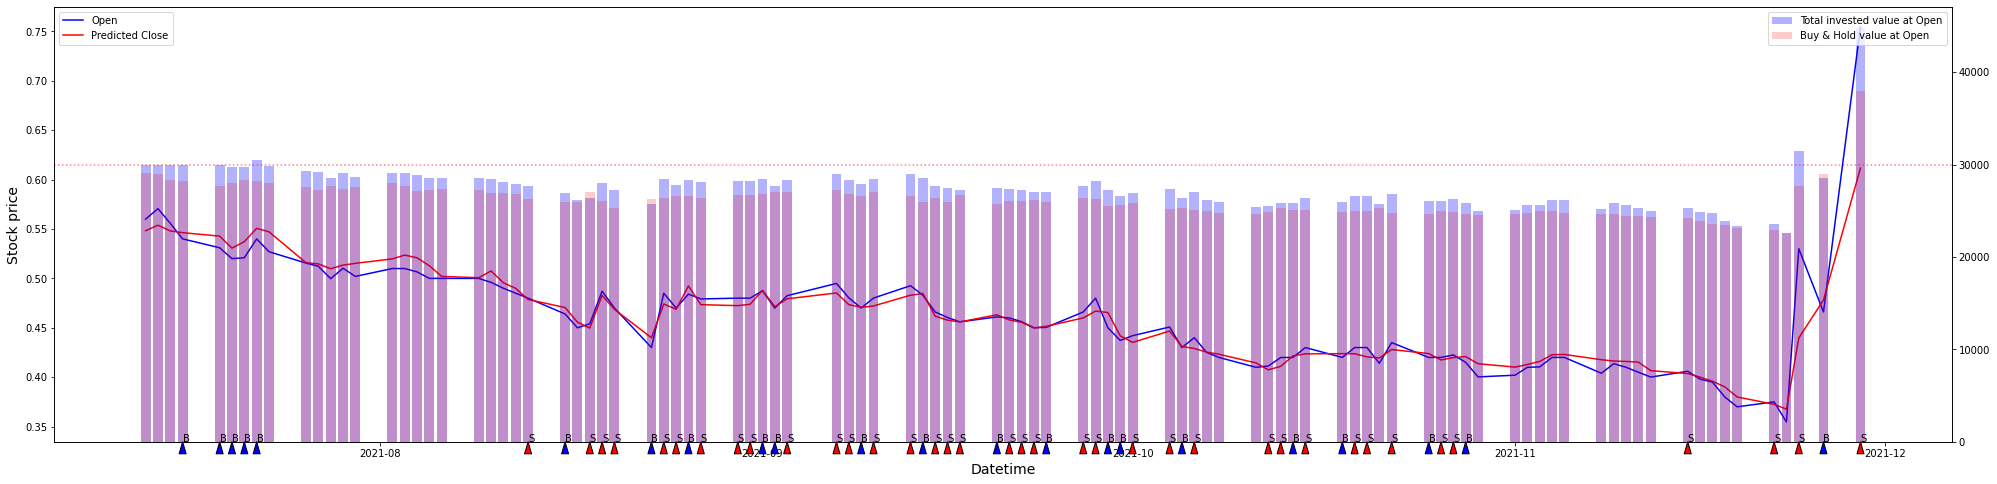

Trading Total(Profit%):  49.40079011573476 Trading Total:  44820.23703472043
Buy & Hold(Profit %): 26.500004529953003 Buy & Hold Total 37950.0013589859


In [25]:
plot_returns2(plot_df)
print('Trading Total(Profit%): ',(plot_df.iloc[len(plot_df)-1]['Total']-30000)*100/30000,'Trading Total: ',plot_df.iloc[len(plot_df)-1]['Total'])
print('Buy & Hold(Profit %):',(plot_df.iloc[len(plot_df)-1]['Buy&Hold']-30000)*100/30000,'Buy & Hold Total',plot_df.iloc[len(plot_df)-1]['Buy&Hold'])

# Trying with JPM

In [26]:
df_jpm = yf.download('JPM',start ,end)

[*********************100%***********************]  1 of 1 completed


In [27]:
df_jpm

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,63.950001,64.059998,63.009998,63.619999,54.278217,25386652
2016-01-05,63.700001,64.129997,63.040001,63.730000,54.372078,16566703
2016-01-06,62.720001,63.125000,62.340000,62.810001,53.587162,22960882
2016-01-07,61.459999,62.000000,60.080002,60.270000,51.420132,27626478
2016-01-08,61.130001,61.270000,58.849998,58.919998,50.268372,22366146
...,...,...,...,...,...,...
2021-11-23,165.500000,168.554993,165.369995,168.279999,168.279999,12362344
2021-11-24,168.460007,169.440002,166.440002,166.960007,166.960007,9629790
2021-11-26,162.139999,162.649994,158.820007,161.929993,161.929993,13619276


In [28]:
# df_jpm['Close'] = df_jpm['Adj Close']
df_jpm = df_jpm.drop("Adj Close",axis=1)

for sma_period in [5,10,20,50,100,200]:
    indicator_name = "SMA_%d" % (sma_period)
    df_jpm[indicator_name] = df_jpm['Close'].rolling(sma_period).mean()
    
df_jpm['BollingerBand_Up_20_2'] = df_jpm['Close'].rolling(20).mean() + 2*df_jpm['Close'].rolling(20).std()
df_jpm['BollingerBand_Down_20_2'] = df_jpm['Close'].rolling(20).mean() - 2*df_jpm['Close'].rolling(20).std()

df_jpm['BollingerBand_Up_10_1'] = df_jpm['Close'].rolling(10).mean() + df_jpm['Close'].rolling(10).std()
df_jpm['BollingerBand_Down_10_1'] = df_jpm['Close'].rolling(10).mean() - df_jpm['Close'].rolling(10).std()
df_jpm = df_jpm.drop(['High','Low'], axis=1)
newdata = df_jpm[['Close','Open']]

for lag in [1,2,3,4,5,6,7,8,9,10]:
    shift = lag
    shifted = df_jpm.shift(shift)
    shifted.columns = [str.format("%s_shifted_by_%d" % (column ,shift)) for column in shifted.columns]
    newdata = pd.concat((newdata,shifted),axis=1)
    
forward_lag = 1
newdata['target'] = newdata['Close'].shift(-forward_lag)
#Dropped close
newdata = newdata.drop('Close',axis=1)
newdata.dropna()

from sklearn.model_selection import train_test_split

training_data  = newdata.head(len(newdata)-100)
training_data = training_data.dropna()
X = training_data.drop("target",axis=1)
Y = training_data['target']

import numpy as np
correlations = np.abs(X.corrwith(Y))
features =  list(correlations.sort_values(ascending=False)[0:50].index)
X = X[features]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomizedSearchCV(RandomForestRegressor(),
param_distributions =  {
                  'n_estimators':np.arange(10,500,5),
                  'max_features':np.arange(1,10,1)
               },
                  cv=5, n_iter = 20,
                  iid=False,random_state=0,refit=True,
                  scoring="neg_mean_absolute_error")
rf.fit(X_train,y_train)

print(rf.best_params_)

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'n_estimators': 365, 'max_features': 9}


In [30]:
model = RandomForestRegressor(n_estimators=rf.best_params_['n_estimators'], max_features=rf.best_params_['max_features'])
model.fit(X_train, y_train)

RandomForestRegressor(max_features=9, n_estimators=365)

In [31]:
y_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error
print("MAE: ", mean_absolute_error(y_test,y_pred))

df_jpm['Date'] = df_jpm.index
newdata['Date'] = newdata.index
total = 100000
total_in_stocks= 0
total_trades = 0
signal=''

def day_trade(real_open, pred_close, total, total_in_stocks,total_trades, signal):
    signal='H'
    if(real_open > pred_close and total_in_stocks>35):
        #sell
        total_trades+=1
        total_in_stocks-=35
        total += 35*real_open
        signal="S"
        print('Sold %s shares at $%s totaling $%s'%(5000, round(real_open,2), round(5000*real_open,2)), signal)
        
    elif(total>5000 and real_open < pred_close):
        #buy
#         print("BUYING")
        total_trades+=1
        total_in_stocks+=5000/real_open
        total = total-5000
        signal="B"
        print('Bought %s shares at $%s totaling $%s'%(round(total_in_stocks,2), round(real_open,2), round((5000/real_open)*real_open,2)), signal)
        
    print(signal) 
    return total, total_in_stocks, total_trades, signal

#For DF

dates=[]
total_value=[]
stock_close=[]
stock_open=[]
pred_close=[]
target=[]
signals=[]

print('______________________________________')
for i in range(len(newdata)-100, len(newdata)-1):
    real_X = pd.DataFrame(columns=newdata[features].columns)
    real_X.loc[i] = newdata[features].iloc[i].values
    real_y = newdata.iloc[i]['target']
    pred_y = model.predict(real_X)
    real_open = newdata.iloc[i]['Open']
    #GARCH uptrend for 4 days buy, #GARCH downtrend for one day sell
    print('Date:',newdata['Date'].iloc[i])
    print("\nTOTAL(STOCKS+BP): ",round(total_in_stocks*real_open+ total,2)," Open: ", round(real_open,2), " P Close: ",round(pred_y[0],2),"Close:", round(newdata.iloc[i+1]['target'],2) )
    print('before', real_open ,pred_y,real_open>pred_y,total, total_in_stocks, total_trades )
    total, total_in_stocks, total_trades, signal = day_trade(real_open ,pred_y, total, total_in_stocks, total_trades, signal)
#     print(day_trade(real_open ,pred_y, total, total_in_stocks, total_trades, signal))
    print('after', real_open ,pred_y,total, total_in_stocks, total_trades)
    dates.append(newdata['Date'].iloc[i])
    total_value.append(total_in_stocks*real_open+total)
    stock_close.append(newdata.iloc[i+1]['target'])
    stock_open.append(real_open)
    pred_close.append(pred_y[0])
    target.append(real_y)
#     print("SIGNAL ",signal)
    signals.append(signal)
#     print(signals)
    
    print('______________________________________')
    
plot_df=pd.DataFrame()
plot_df['Date'] = dates
plot_df['Total'] = total_value
plot_df['Open'] = stock_open
plot_df['Close'] = stock_close
plot_df['PClose'] = pred_close
plot_df['TClose'] = target
plot_df['Signal'] = signals

plot_df['Buy&Hold'] =[0]*len(plot_df)
for i in range(1,len(plot_df)):
#     print(plot_df['TClose'].iloc[i-1],plot_df['Open'].iloc[0],plot_df['TClose'].iloc[i-1] - plot_df['Open'].iloc[0] )
    plot_df['Buy&Hold'].iloc[i] = 100000+100000*((plot_df['TClose'].iloc[i-1] - plot_df['Open'].iloc[0])/plot_df['Open'].iloc[0])
    
plot_df=plot_df[1:]


MAE:  1.7357056167728897
______________________________________
Date: 2021-07-12 00:00:00

TOTAL(STOCKS+BP):  100000.0  Open:  154.35  P Close:  152.08 Close: 155.12
before 154.35000610351562 [152.07851993] [ True] 100000 0 0
H
after 154.35000610351562 [152.07851993] 100000 0 0
______________________________________
Date: 2021-07-13 00:00:00

TOTAL(STOCKS+BP):  100000.0  Open:  156.05  P Close:  152.73 Close: 155.46
before 156.0500030517578 [152.73002633] [ True] 100000 0 0
H
after 156.0500030517578 [152.73002633] 100000 0 0
______________________________________
Date: 2021-07-14 00:00:00

TOTAL(STOCKS+BP):  100000.0  Open:  155.95  P Close:  152.22 Close: 151.91
before 155.9499969482422 [152.22210806] [ True] 100000 0 0
H
after 155.9499969482422 [152.22210806] 100000 0 0
______________________________________
Date: 2021-07-15 00:00:00

TOTAL(STOCKS+BP):  100000.0  Open:  153.9  P Close:  152.27 Close: 146.97
before 153.89999389648438 [152.27457413] [ True] 100000 0 0
H
after 153.89999

Date: 2021-08-19 00:00:00

TOTAL(STOCKS+BP):  101644.85  Open:  153.16  P Close:  154.82 Close: 156.7
before 153.16000366210938 [154.81586228] [False] 58710.00053405762 280.3267803116515 23
Bought 312.97 shares at $153.16 totaling $5000.0 B
B
after 153.16000366210938 [154.81586228] 53710.00053405762 312.97237890428823 24
______________________________________
Date: 2021-08-20 00:00:00

TOTAL(STOCKS+BP):  102017.29  Open:  154.35  P Close:  153.3 Close: 157.67
before 154.35000610351562 [153.30279311] [ True] 53710.00053405762 312.97237890428823 24
Sold 5000 shares at $154.35 totaling $771750.03 S
S
after 154.35000610351562 [153.30279311] 59112.250747680664 277.97237890428823 25
______________________________________
Date: 2021-08-23 00:00:00

TOTAL(STOCKS+BP):  102289.7  Open:  155.33  P Close:  152.76 Close: 160.92
before 155.3300018310547 [152.75977871] [ True] 59112.250747680664 277.97237890428823 25
Sold 5000 shares at $155.33 totaling $776650.01 S
S
after 155.3300018310547 [152.759

Date: 2021-09-23 00:00:00

TOTAL(STOCKS+BP):  103064.28  Open:  158.0  P Close:  154.74 Close: 166.98
before 158.0 [154.73682071] [ True] 75749.80049133301 172.8764691613694 47
Sold 5000 shares at $158.0 totaling $790000.0 S
S
after 158.0 [154.73682071] 81279.80049133301 137.8764691613694 48
______________________________________
Date: 2021-09-24 00:00:00

TOTAL(STOCKS+BP):  103538.58  Open:  161.44  P Close:  157.89 Close: 166.08
before 161.44000244140625 [157.89167083] [ True] 81279.80049133301 137.8764691613694 48
Sold 5000 shares at $161.44 totaling $807200.01 S
S
after 161.44000244140625 [157.89167083] 86930.20057678223 102.87646916136941 49
______________________________________
Date: 2021-09-27 00:00:00

TOTAL(STOCKS+BP):  103904.82  Open:  165.0  P Close:  159.73 Close: 165.95
before 165.0 [159.7253155] [ True] 86930.20057678223 102.87646916136941 49
Sold 5000 shares at $165.0 totaling $825000.0 S
S
after 165.0 [159.7253155] 92705.20057678223 67.87646916136941 50
______________

Date: 2021-11-04 00:00:00

TOTAL(STOCKS+BP):  104163.7  Open:  170.0  P Close:  157.84 Close: 169.06
before 170.0 [157.84235618] [ True] 98574.7004699707 32.876469161369414 51
H
after 170.0 [157.84235618] 98574.7004699707 32.876469161369414 51
______________________________________
Date: 2021-11-05 00:00:00

TOTAL(STOCKS+BP):  104127.54  Open:  168.9  P Close:  157.84 Close: 167.78
before 168.89999389648438 [157.84235618] [ True] 98574.7004699707 32.876469161369414 51
H
after 168.89999389648438 [157.84235618] 98574.7004699707 32.876469161369414 51
______________________________________
Date: 2021-11-08 00:00:00

TOTAL(STOCKS+BP):  104132.47  Open:  169.05  P Close:  157.84 Close: 167.62
before 169.0500030517578 [157.84235618] [ True] 98574.7004699707 32.876469161369414 51
H
after 169.0500030517578 [157.84235618] 98574.7004699707 32.876469161369414 51
______________________________________
Date: 2021-11-09 00:00:00

TOTAL(STOCKS+BP):  104076.58  Open:  167.35  P Close:  157.84 Close: 16

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


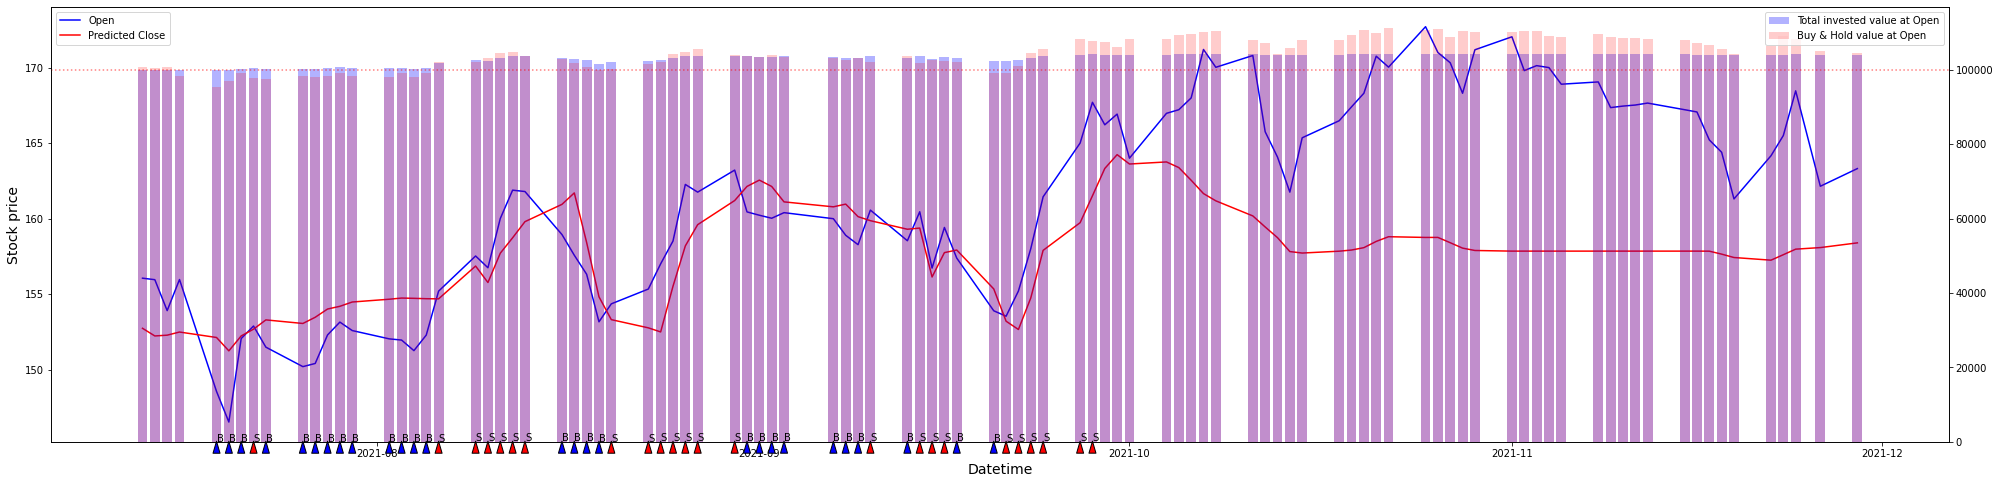

Trading Total(Profit%):  3.9437565684491274 Trading Total:  103943.75656844913
Buy & Hold(Profit %): 4.457395109793084 Buy & Hold Total 104457.39510979308


In [32]:
plot_returns(plot_df)
print('Trading Total(Profit%): ',(plot_df.iloc[len(plot_df)-1]['Total']-100000)*100/100000,'Trading Total: ',plot_df.iloc[len(plot_df)-1]['Total'])

print('Buy & Hold(Profit %):',(plot_df.iloc[len(plot_df)-1]['Buy&Hold']-100000)*100/100000,'Buy & Hold Total',plot_df.iloc[len(plot_df)-1]['Buy&Hold'])

# Creating an ETF

In [33]:
df_jpm = yf.download('JPM',start ,end)
df_bac = yf.download('BAC',start ,end)
df_fitb = yf.download('FITB',start ,end)
df_sq = yf.download('SQ',start ,end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [34]:
df_ETF = pd.DataFrame()
df_ETF.index = df_jpm.index 
df_ETF['Open'] = [0]*len(df_jpm)
df_ETF['Close'] = [0]*len(df_jpm)
df_ETF['High'] = [0]*len(df_jpm)
df_ETF['Low'] = [0]*len(df_jpm)
df_ETF['Volume'] = [0]*len(df_jpm)

for i in range(len(df_jpm)):
    df_ETF['Open'].iloc[i] = 0.25*df_jpm['Open'].iloc[i]+0.25*df_bac['Open'].iloc[i]+0.25*df_fitb['Open'].iloc[i]+0.25*df_sq['Open'].iloc[i]
    df_ETF['Close'].iloc[i] = 0.25*df_jpm['Close'].iloc[i]+0.25*df_bac['Close'].iloc[i]+0.25*df_fitb['Close'].iloc[i]+0.25*df_sq['Close'].iloc[i]
    df_ETF['High'].iloc[i] = 0.25*df_jpm['High'].iloc[i]+0.25*df_bac['High'].iloc[i]+0.25*df_fitb['High'].iloc[i]+0.25*df_sq['High'].iloc[i]
    df_ETF['Low'].iloc[i] = 0.25*df_jpm['Low'].iloc[i]+0.25*df_bac['Low'].iloc[i]+0.25*df_fitb['Low'].iloc[i]+0.25*df_sq['Low'].iloc[i]
    df_ETF['Volume'].iloc[i] = 0.25*df_jpm['Volume'].iloc[i]+0.25*df_bac['Volume'].iloc[i]+0.25*df_fitb['Volume'].iloc[i]+0.25*df_sq['Volume'].iloc[i]
    
print(df_ETF)

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


                  Open       Close        High         Low       Volume
Date                                                                   
2016-01-04   28.157500   27.940000   28.282499   27.661249  38649663.00
2016-01-05   27.995000   27.820000   28.197499   27.540625  23627125.75
2016-01-06   27.405000   27.432500   27.616250   27.120000  34111999.25
2016-01-07   26.812500   26.410000   27.085000   26.300000  39162347.75
2016-01-08   26.772500   25.953750   26.925000   25.890000  39160521.25
...                ...         ...         ...         ...          ...
2021-11-23  116.702500  117.792500  118.957498  115.424999  18592261.75
2021-11-24  117.025001  118.710000  119.945000  116.352500  15018571.25
2021-11-26  115.392499  115.562498  116.916247  113.585003  19524396.25
2021-11-29  118.335001  115.669998  118.867501  114.075500  18384957.00
2021-11-30  115.308750  113.445002  116.560001  112.587499  28841083.50

[1489 rows x 5 columns]


In [35]:
# df_jpm['Close'] = df_jpm['Adj Close']
for sma_period in [5,10,20,50,100,200]:
    indicator_name = "SMA_%d" % (sma_period)
    df_ETF[indicator_name] = df_ETF['Close'].rolling(sma_period).mean()
    
df_ETF['BollingerBand_Up_20_2'] = df_ETF['Close'].rolling(20).mean() + 2*df_ETF['Close'].rolling(20).std()
df_ETF['BollingerBand_Down_20_2'] = df_ETF['Close'].rolling(20).mean() - 2*df_ETF['Close'].rolling(20).std()

df_ETF['BollingerBand_Up_10_1'] = df_ETF['Close'].rolling(10).mean() + df_ETF['Close'].rolling(10).std()
df_ETF['BollingerBand_Down_10_1'] = df_ETF['Close'].rolling(10).mean() - df_ETF['Close'].rolling(10).std()
df_ETF = df_ETF.drop(['High','Low'], axis=1)
newdata = df_ETF[['Close','Open']]
for lag in [1,2,3,4,5,6,7,8,9,10]:
    shift = lag
    shifted = df_ETF.shift(shift)
    shifted.columns = [str.format("%s_shifted_by_%d" % (column ,shift)) for column in shifted.columns]
    newdata = pd.concat((newdata,shifted),axis=1)
    
forward_lag = 1
newdata['target'] = newdata['Close'].shift(-forward_lag)
#Dropped close
newdata = newdata.drop('Close',axis=1)
newdata.dropna()

from sklearn.model_selection import train_test_split

training_data  = newdata.head(len(newdata)-100)
training_data = training_data.dropna()
X = training_data.drop("target",axis=1)
Y = training_data['target']

import numpy as np
correlations = np.abs(X.corrwith(Y))
features =  list(correlations.sort_values(ascending=False)[0:50].index)
# features.append('ETF_Open')
X = X[features]
print(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

                  Open  Close_shifted_by_1  Open_shifted_by_1  \
Date                                                            
2016-10-31   29.747500           29.635000          29.882500   
2016-11-01   29.785001           29.680001          29.747500   
2016-11-02   29.585000           29.625000          29.785001   
2016-11-03   29.671250           29.640000          29.585000   
2016-11-04   29.597500           29.567499          29.671250   
...                ...                 ...                ...   
2021-07-02  119.789999          119.802503         119.785001   
2021-07-06  119.032499          119.175000         119.789999   
2021-07-07  119.644999          119.375000         119.032499   
2021-07-08  116.352500          118.762499         119.644999   
2021-07-09  117.250001          115.542499         116.352500   

            Close_shifted_by_2  SMA_5_shifted_by_1  Open_shifted_by_2  \
Date                                                                    
2016-10-

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomizedSearchCV(RandomForestRegressor(),
param_distributions =  {
                  'n_estimators':np.arange(10,500,5),
                  'max_features':np.arange(1,10,1)
               },
                  cv=5, n_iter = 20,
                  iid=False,random_state=0,refit=True,
                  scoring="neg_mean_absolute_error")
rf.fit(X_train,y_train)

print(rf.best_params_)

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'n_estimators': 285, 'max_features': 7}


In [37]:
model = RandomForestRegressor(n_estimators=rf.best_params_['n_estimators'], max_features=rf.best_params_['max_features'])
model.fit(X_train, y_train)

RandomForestRegressor(max_features=7, n_estimators=285)

In [38]:
y_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error
print("MAE: ", mean_absolute_error(y_test,y_pred))

df_ETF['Date'] = df_ETF.index
newdata['Date'] = newdata.index
total = 100000
total_in_stocks= 0
total_trades = 0
signal=''

def day_trade(real_open, pred_close, total, total_in_stocks,total_trades, signal):
    signal='H'
    if(real_open > pred_close and total_in_stocks>35):
        #sell
        total_trades+=1
        total_in_stocks-=35
        total += 35*real_open
        signal="S"
        print('Sold %s shares at $%s totaling $%s'%(5000, round(real_open,2), round(5000*real_open,2)), signal)
        
    elif(total>5000 and real_open < pred_close):
        #buy
#         print("BUYING")
        total_trades+=1
        total_in_stocks+=5000/real_open
        total = total-5000
        signal="B"
        print('Bought %s shares at $%s totaling $%s'%(round(total_in_stocks,2), round(real_open,2), round((5000/real_open)*real_open,2)), signal)
        
    print(signal) 
    return total, total_in_stocks, total_trades, signal

#For DF

dates=[]
total_value=[]
stock_close=[]
stock_open=[]
pred_close=[]
target=[]
signals=[]

print('______________________________________')
for i in range(len(newdata)-100, len(newdata)-1):
    real_X = pd.DataFrame(columns=newdata[features].columns)
    real_X.loc[i] = newdata[features].iloc[i].values
    real_y = newdata.iloc[i]['target']
    pred_y = model.predict(real_X)
    real_open = newdata.iloc[i]['Open']
    #GARCH uptrend for 4 days buy, #GARCH downtrend for one day sell
    print('Date:',newdata['Date'].iloc[i])
    print("\nTOTAL(STOCKS+BP): ",round(total_in_stocks*real_open+ total,2)," Open: ", round(real_open,2), " P Close: ",round(pred_y[0],2),"Close:", round(newdata.iloc[i+1]['target'],2) )
    print('before', real_open ,pred_y,real_open>pred_y,total, total_in_stocks, total_trades )
    total, total_in_stocks, total_trades, signal = day_trade(real_open ,pred_y, total, total_in_stocks, total_trades, signal)
#     print(day_trade(real_open ,pred_y, total, total_in_stocks, total_trades, signal))
    print('after', real_open ,pred_y,total, total_in_stocks, total_trades)
    dates.append(newdata['Date'].iloc[i])
    total_value.append(total_in_stocks*real_open+total)
    stock_close.append(newdata.iloc[i+1]['target'])
    stock_open.append(real_open)
    pred_close.append(pred_y[0])
    target.append(real_y)
#     print("SIGNAL ",signal)
    signals.append(signal)
#     print(signals)
    
    print('______________________________________')
    
plot_df=pd.DataFrame()
plot_df['Date'] = dates
plot_df['Total'] = total_value
plot_df['Open'] = stock_open
plot_df['Close'] = stock_close
plot_df['PClose'] = pred_close
plot_df['TClose'] = target
plot_df['Signal'] = signals

plot_df['Buy&Hold'] =[0]*len(plot_df)
for i in range(1,len(plot_df)):
#     print(plot_df['TClose'].iloc[i-1],plot_df['Open'].iloc[0],plot_df['TClose'].iloc[i-1] - plot_df['Open'].iloc[0] )
    plot_df['Buy&Hold'].iloc[i] = 100000+100000*((plot_df['TClose'].iloc[i-1] - plot_df['Open'].iloc[0])/plot_df['Open'].iloc[0])
    
plot_df=plot_df[1:]


MAE:  1.059767404583528
______________________________________
Date: 2021-07-12 00:00:00

TOTAL(STOCKS+BP):  100000.0  Open:  118.82  P Close:  117.72 Close: 117.59
before 118.82250213623047 [117.72296519] [ True] 100000 0 0
H
after 118.82250213623047 [117.72296519] 100000 0 0
______________________________________
Date: 2021-07-13 00:00:00

TOTAL(STOCKS+BP):  100000.0  Open:  119.57  P Close:  117.69 Close: 116.81
before 119.57250213623047 [117.69265812] [ True] 100000 0 0
H
after 119.57250213623047 [117.69265812] 100000 0 0
______________________________________
Date: 2021-07-14 00:00:00

TOTAL(STOCKS+BP):  100000.0  Open:  119.26  P Close:  117.77 Close: 115.94
before 119.26250076293945 [117.76669311] [ True] 100000 0 0
H
after 119.26250076293945 [117.76669311] 100000 0 0
______________________________________
Date: 2021-07-15 00:00:00

TOTAL(STOCKS+BP):  100000.0  Open:  117.32  P Close:  117.18 Close: 113.06
before 117.3224983215332 [117.18151333] [ True] 100000 0 0
H
after 117.32

Date: 2021-08-25 00:00:00

TOTAL(STOCKS+BP):  100711.21  Open:  127.09  P Close:  119.37 Close: 128.25
before 127.08749866485596 [119.37397337] [ True] 98375.9375 18.375332847478006 4
H
after 127.08749866485596 [119.37397337] 98375.9375 18.375332847478006 4
______________________________________
Date: 2021-08-26 00:00:00

TOTAL(STOCKS+BP):  100728.72  Open:  128.04  P Close:  119.27 Close: 128.16
before 128.0399990081787 [119.2729295] [ True] 98375.9375 18.375332847478006 4
H
after 128.0399990081787 [119.2729295] 98375.9375 18.375332847478006 4
______________________________________
Date: 2021-08-27 00:00:00

TOTAL(STOCKS+BP):  100694.86  Open:  126.2  P Close:  119.29 Close: 127.16
before 126.19749927520752 [119.28800848] [ True] 98375.9375 18.375332847478006 4
H
after 126.19749927520752 [119.28800848] 98375.9375 18.375332847478006 4
______________________________________
Date: 2021-08-30 00:00:00

TOTAL(STOCKS+BP):  100748.19  Open:  129.1  P Close:  119.28 Close: 126.91
before 129.1

Date: 2021-10-11 00:00:00

TOTAL(STOCKS+BP):  100664.77  Open:  124.56  P Close:  119.42 Close: 122.39
before 124.56000137329102 [119.41708733] [ True] 98375.9375 18.375332847478006 4
H
after 124.56000137329102 [119.41708733] 98375.9375 18.375332847478006 4
______________________________________
Date: 2021-10-12 00:00:00

TOTAL(STOCKS+BP):  100629.63  Open:  122.65  P Close:  119.24 Close: 124.84
before 122.64749908447266 [119.23588563] [ True] 98375.9375 18.375332847478006 4
H
after 122.64749908447266 [119.23588563] 98375.9375 18.375332847478006 4
______________________________________
Date: 2021-10-13 00:00:00

TOTAL(STOCKS+BP):  100627.56  Open:  122.54  P Close:  119.08 Close: 126.39
before 122.53500270843506 [119.07960495] [ True] 98375.9375 18.375332847478006 4
H
after 122.53500270843506 [119.07960495] 98375.9375 18.375332847478006 4
______________________________________
Date: 2021-10-14 00:00:00

TOTAL(STOCKS+BP):  100661.25  Open:  124.37  P Close:  119.09 Close: 127.27
before

Date: 2021-11-18 00:00:00

TOTAL(STOCKS+BP):  100626.5  Open:  122.48  P Close:  119.34 Close: 116.53
before 122.47749996185303 [119.34316632] [ True] 98375.9375 18.375332847478006 4
H
after 122.47749996185303 [119.34316632] 98375.9375 18.375332847478006 4
______________________________________
Date: 2021-11-19 00:00:00

TOTAL(STOCKS+BP):  100577.5  Open:  119.81  P Close:  119.15 Close: 117.79
before 119.81050205230713 [119.15128023] [ True] 98375.9375 18.375332847478006 4
H
after 119.81050205230713 [119.15128023] 98375.9375 18.375332847478006 4
______________________________________
Date: 2021-11-22 00:00:00

TOTAL(STOCKS+BP):  100571.05  Open:  119.46  P Close:  118.94 Close: 118.71
before 119.46000289916992 [118.93505218] [ True] 98375.9375 18.375332847478006 4
H
after 119.46000289916992 [118.93505218] 98375.9375 18.375332847478006 4
______________________________________
Date: 2021-11-23 00:00:00

TOTAL(STOCKS+BP):  100520.38  Open:  116.7  P Close:  118.62 Close: 115.56
before 11

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


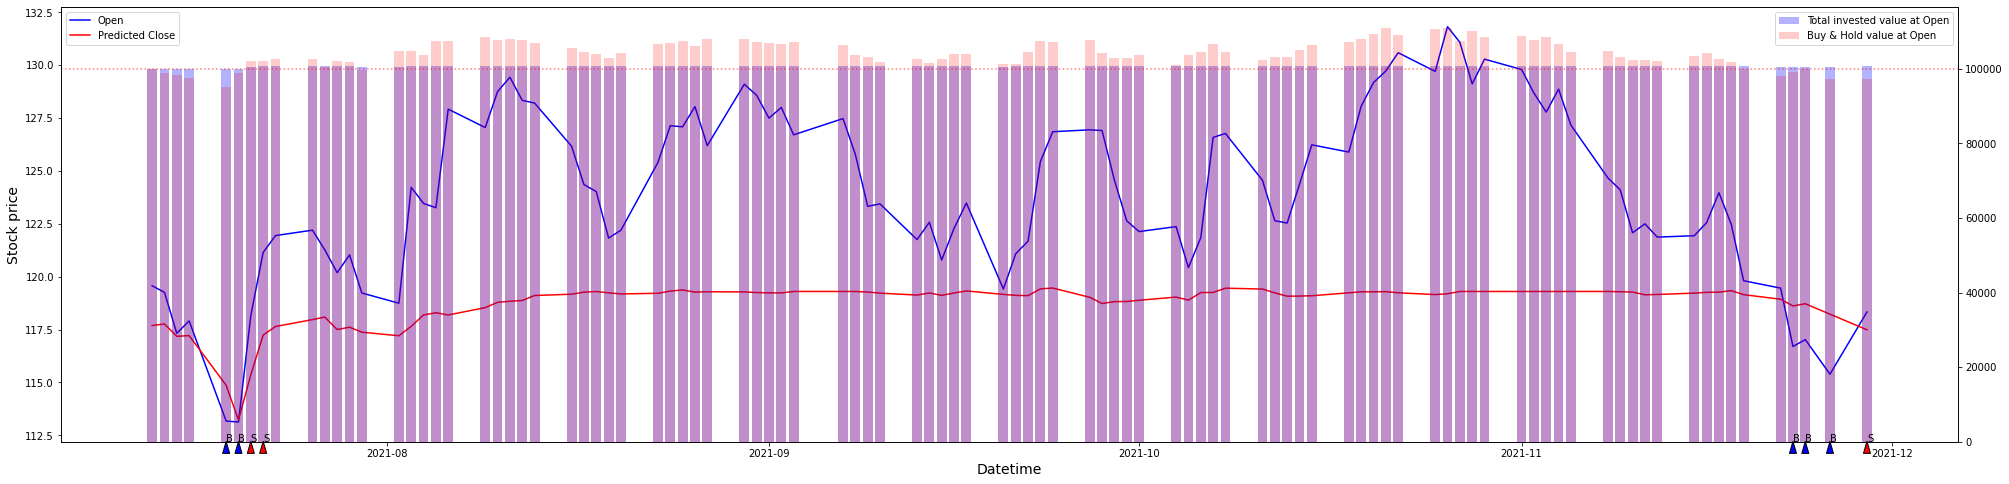

Trading Total(Profit%):  0.803796035227686 Trading Total:  100803.79603522769
Buy & Hold(Profit %): -2.6531203354654136 Buy & Hold Total 97346.87966453459


In [39]:
plot_returns(plot_df)
print('Trading Total(Profit%): ',(plot_df.iloc[len(plot_df)-1]['Total']-100000)*100/100000,'Trading Total: ',plot_df.iloc[len(plot_df)-1]['Total'])
print('Buy & Hold(Profit %):',(plot_df.iloc[len(plot_df)-1]['Buy&Hold']-100000)*100/100000,'Buy & Hold Total',plot_df.iloc[len(plot_df)-1]['Buy&Hold'])

# Using GARCH to trade 

In [40]:
df_jpm = yf.download('JPM',start ,end)
# df_bac = yf.download('BAC',start ,end)
# df_fitb = yf.download('FITB',start ,end)
# df_sq = yf.download('SQ',start ,end)

[*********************100%***********************]  1 of 1 completed


In [41]:
# df_ETF = pd.DataFrame()
# df_ETF.index = df_jpm.index 
# df_ETF['Open'] = [0]*len(df_jpm)
# df_ETF['Close'] = [0]*len(df_jpm)
# df_ETF['High'] = [0]*len(df_jpm)
# df_ETF['Low'] = [0]*len(df_jpm)
# df_ETF['Volume'] = [0]*len(df_jpm)

# for i in range(len(df_jpm)):
#     df_ETF['Open'].iloc[i] = 0.25*df_jpm['Open'].iloc[i]+0.25*df_bac['Open'].iloc[i]+0.25*df_fitb['Open'].iloc[i]+0.25*df_sq['Open'].iloc[i]
#     df_ETF['Close'].iloc[i] = 0.25*df_jpm['Close'].iloc[i]+0.25*df_bac['Close'].iloc[i]+0.25*df_fitb['Close'].iloc[i]+0.25*df_sq['Close'].iloc[i]
#     df_ETF['High'].iloc[i] = 0.25*df_jpm['High'].iloc[i]+0.25*df_bac['High'].iloc[i]+0.25*df_fitb['High'].iloc[i]+0.25*df_sq['High'].iloc[i]
#     df_ETF['Low'].iloc[i] = 0.25*df_jpm['Low'].iloc[i]+0.25*df_bac['Low'].iloc[i]+0.25*df_fitb['Low'].iloc[i]+0.25*df_sq['Low'].iloc[i]
#     df_ETF['Volume'].iloc[i] = 0.25*df_jpm['Volume'].iloc[i]+0.25*df_bac['Volume'].iloc[i]+0.25*df_fitb['Volume'].iloc[i]+0.25*df_sq['Volume'].iloc[i]
    
# print(df_ETF)
df_ETF=df_jpm

In [42]:
# df_jpm['Close'] = df_jpm['Adj Close']
for sma_period in [5,10,20,50,100,200]:
    indicator_name = "SMA_%d" % (sma_period)
    df_ETF[indicator_name] = df_ETF['Close'].rolling(sma_period).mean()
    
df_ETF['BollingerBand_Up_20_2'] = df_ETF['Close'].rolling(20).mean() + 2*df_ETF['Close'].rolling(20).std()
df_ETF['BollingerBand_Down_20_2'] = df_ETF['Close'].rolling(20).mean() - 2*df_ETF['Close'].rolling(20).std()

df_ETF['BollingerBand_Up_10_1'] = df_ETF['Close'].rolling(10).mean() + df_ETF['Close'].rolling(10).std()
df_ETF['BollingerBand_Down_10_1'] = df_ETF['Close'].rolling(10).mean() - df_ETF['Close'].rolling(10).std()
df_ETF = df_ETF.drop(['High','Low'], axis=1)
newdata = df_ETF[['Close','Open']]
for lag in [1,2,3,4,5,6,7,8,9,10]:
    shift = lag
    shifted = df_ETF.shift(shift)
    shifted.columns = [str.format("%s_shifted_by_%d" % (column ,shift)) for column in shifted.columns]
    newdata = pd.concat((newdata,shifted),axis=1)
    
forward_lag = 1
newdata['target'] = newdata['Close'].shift(-forward_lag)

#Dropped close
newdata = newdata.drop('Close',axis=1)
newdata.dropna()

from sklearn.model_selection import train_test_split

training_data  = newdata.head(len(newdata)-100)
training_data = training_data.dropna()
X = training_data.drop("target",axis=1)
Y = training_data['target']

import numpy as np
correlations = np.abs(X.corrwith(Y))
features =  list(correlations.sort_values(ascending=False)[0:50].index)
# features.append('ETF_Open')
X = X[features]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomizedSearchCV(RandomForestRegressor(),
param_distributions =  {
                  'n_estimators':np.arange(10,500,5),
                  'max_features':np.arange(1,10,1)
               },
                  cv=5, n_iter = 20,
                  iid=False,random_state=0,refit=True,
                  scoring="neg_mean_absolute_error")
rf.fit(X_train,y_train)

print(rf.best_params_)

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'n_estimators': 365, 'max_features': 9}


In [44]:
model = RandomForestRegressor(n_estimators=rf.best_params_['n_estimators'], max_features=rf.best_params_['max_features'])
model.fit(X_train, y_train)

RandomForestRegressor(max_features=9, n_estimators=365)

In [45]:
y_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error
print("MAE: ", mean_absolute_error(y_test,y_pred))

df_ETF['Date'] = df_ETF.index
newdata['Date'] = newdata.index
total = 100000
total_in_stocks= 0
total_trades = 0
signal=''


def day_trade(real_open, pred_close, total, total_in_stocks,total_trades, signal,counter):
    signal='H'
    counter+=1
    returns = newdata[:len(newdata)-(100-counter)].target.pct_change().dropna()
    model = arch_model(returns, p=2, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=3)
    future_dates = [returns.index[-1] + timedelta(days=i) for i in range(1,4)]
    pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)
    buy_flag=0
    sell_flag=0
    
    #buy when vol is going up 
    if(pred[0]>pred[1]>pred[2]):
        buy_flag = 1
    #sell when vol id going down
    if(pred[0]<pred[1]):
        sell_flag=1
        
    if(real_open > pred_close and total_in_stocks>35 or buy_flag):
        #sell
        total_trades+=1
        total_in_stocks-=35
        total += 35*real_open
        signal="S"
        print('Sold %s shares at $%s totaling $%s'%(5000, round(real_open,2), round(5000*real_open,2)), signal)
        
    elif(total>5000 and real_open < pred_close or sell_flag):
        #buy
#         print("BUYING")
        total_trades+=1
        total_in_stocks+=5000/real_open
        total = total-5000
        signal="B"
        print('Bought %s shares at $%s totaling $%s'%(round(total_in_stocks,2), round(real_open,2), round((5000/real_open)*real_open,2)), signal)
        
    print(signal) 
    return total, total_in_stocks, total_trades, signal

#For DF

dates=[]
total_value=[]
stock_close=[]
stock_open=[]
pred_close=[]
target=[]
signals=[]

print('______________________________________')
for i in range(len(newdata)-100, len(newdata)-1):
    real_X = pd.DataFrame(columns=newdata[features].columns)
    real_X.loc[i] = newdata[features].iloc[i].values
    real_y = newdata.iloc[i]['target']
    pred_y = model.predict(real_X)
    real_open = newdata.iloc[i]['Open']
    #GARCH uptrend for 4 days buy, #GARCH downtrend for one day sell
    print('Date:',newdata['Date'].iloc[i])
    print("\nTOTAL(STOCKS+BP): ",round(total_in_stocks*real_open+ total,2)," Open: ", round(real_open,2), " P Close: ",round(pred_y[0],2),"Close:", round(newdata.iloc[i+1]['target'],2) )
    print('before', real_open ,pred_y,real_open>pred_y,total, total_in_stocks, total_trades )
    counter=0
    total, total_in_stocks, total_trades, signal = day_trade(real_open ,pred_y, total, total_in_stocks, total_trades, signal, counter)
#     print(day_trade(real_open ,pred_y, total, total_in_stocks, total_trades, signal))
    print('after', real_open ,pred_y,total, total_in_stocks, total_trades)
    dates.append(newdata['Date'].iloc[i])
    total_value.append(total_in_stocks*real_open+total)
    stock_close.append(newdata.iloc[i+1]['target'])
    stock_open.append(real_open)
    pred_close.append(pred_y[0])
    target.append(real_y)
#     print("SIGNAL ",signal)
    signals.append(signal)
#     print(signals)
    
    print('______________________________________')
    
plot_df=pd.DataFrame()
plot_df['Date'] = dates
plot_df['Total'] = total_value
plot_df['Open'] = stock_open
plot_df['Close'] = stock_close
plot_df['PClose'] = pred_close
plot_df['TClose'] = target
plot_df['Signal'] = signals

plot_df['Buy&Hold'] =[0]*len(plot_df)
for i in range(1,len(plot_df)):
    plot_df['Buy&Hold'].iloc[i] = 100000+100000*((plot_df['TClose'].iloc[i-1] - plot_df['Open'].iloc[0])/plot_df['Open'].iloc[0])
    
plot_df=plot_df[1:]


MAE:  1.7244211225684571
______________________________________
Date: 2021-07-12 00:00:00

TOTAL(STOCKS+BP):  100000.0  Open:  154.35  P Close:  151.9 Close: 155.12
before 154.35000610351562 [151.90386269] [ True] 100000 0 0
Bought 32.39 shares at $154.35 totaling $5000.0 B
B
after 154.35000610351562 [151.90386269] 95000 32.393908663966776 1
______________________________________
Date: 2021-07-13 00:00:00

TOTAL(STOCKS+BP):  100055.07  Open:  156.05  P Close:  154.25 Close: 155.46
before 156.0500030517578 [154.25230115] [ True] 95000 32.393908663966776 1
Bought 64.43 shares at $156.05 totaling $5000.0 B
B
after 156.0500030517578 [154.25230115] 90000 64.43492053335859 2
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univ

Date: 2021-07-14 00:00:00

TOTAL(STOCKS+BP):  100048.63  Open:  155.95  P Close:  152.29 Close: 151.91
before 155.9499969482422 [152.29046485] [ True] 90000 64.43492053335859 2
Sold 5000 shares at $155.95 totaling $779749.98 S
S
after 155.9499969482422 [152.29046485] 95458.24989318848 29.434920533358593 3
______________________________________
Date: 2021-07-15 00:00:00

TOTAL(STOCKS+BP):  99988.28  Open:  153.9  P Close:  152.55 Close: 146.97
before 153.89999389648438 [152.54997249] [ True] 95458.24989318848 29.434920533358593 3


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Bought 61.92 shares at $153.9 totaling $5000.0 B
B
after 153.89999389648438 [152.54997249] 90458.24989318848 61.92355080168129 4
______________________________________
Date: 2021-07-16 00:00:00

TOTAL(STOCKS+BP):  100115.85  Open:  155.96  P Close:  152.84 Close: 149.71
before 155.9600067138672 [152.84188972] [ True] 90458.24989318848 61.92355080168129 4
Sold 5000 shares at $155.96 totaling $779800.03 S
S
after 155.9600067138672 [152.84188972] 95916.85012817383 26.923550801681287 5
______________________________________
Date: 2021-07-19 00:00:00

TOTAL(STOCKS+BP):  99916.34  Open:  148.55  P Close:  152.1 Close: 152.86
before 148.5500030517578 [152.09747808] [False] 95916.85012817383 26.923550801681287 5


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Bought 60.58 shares at $148.55 totaling $5000.0 B
B
after 148.5500030517578 [152.09747808] 90916.85012817383 60.58225088435917 6
______________________________________
Date: 2021-07-20 00:00:00

TOTAL(STOCKS+BP):  99793.36  Open:  146.52  P Close:  151.27 Close: 150.93
before 146.52000427246094 [151.26835323] [False] 90916.85012817383 60.58225088435917 6
Bought 94.71 shares at $146.52 totaling $5000.0 B
B
after 146.52000427246094 [151.26835323] 85916.85012817383 94.70728401432183 7
______________________________________
Date: 2021-07-21 00:00:00

TOTAL(STOCKS+BP):  100317.09  Open:  152.05  P Close:  152.18 Close: 150.64
before 152.0500030517578 [152.17734015] [False] 85916.85012817383 94.70728401432183 7


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Bought 127.59 shares at $152.05 totaling $5000.0 B
B
after 152.0500030517578 [152.17734015] 80916.85012817383 127.59120311755262 8
______________________________________
Date: 2021-07-22 00:00:00

TOTAL(STOCKS+BP):  100422.99  Open:  152.88  P Close:  152.92 Close: 151.65
before 152.8800048828125 [152.91643589] [False] 80916.85012817383 127.59120311755262 8
Bought 160.3 shares at $152.88 totaling $5000.0 B
B
after 152.8800048828125 [152.91643589] 75916.85012817383 160.29659192122688 9
______________________________________
Date: 2021-07-23 00:00:00

TOTAL(STOCKS+BP):  100198.58  Open:  151.48  P Close:  152.84 Close: 151.45
before 151.47999572753906 [152.84221806] [False] 75916.85012817383 160.29659192122688 9


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Bought 193.3 shares at $151.48 totaling $5000.0 B
B
after 151.47999572753906 [152.84221806] 70916.85012817383 193.304250628805 10
______________________________________
Date: 2021-07-26 00:00:00

TOTAL(STOCKS+BP):  99949.22  Open:  150.19  P Close:  152.92 Close: 151.7
before 150.19000244140625 [152.91531443] [False] 70916.85012817383 193.304250628805 10
Bought 226.6 shares at $150.19 totaling $5000.0 B
B
after 150.19000244140625 [152.91531443] 65916.85012817383 226.59541461257717 11
______________________________________
Date: 2021-07-27 00:00:00

TOTAL(STOCKS+BP):  99996.8  Open:  150.4  P Close:  153.53 Close: 153.0
before 150.39999389648438 [153.53484877] [False] 65916.85012817383 226.59541461257717 11


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Bought 259.84 shares at $150.4 totaling $5000.0 B
B
after 150.39999389648438 [153.53484877] 60916.85012817383 259.8400968127729 12
______________________________________
Date: 2021-07-28 00:00:00

TOTAL(STOCKS+BP):  100487.9  Open:  152.29  P Close:  154.08 Close: 151.78
before 152.2899932861328 [154.07794436] [False] 60916.85012817383 259.8400968127729 12
Bought 292.67 shares at $152.29 totaling $5000.0 B
B
after 152.2899932861328 [154.07794436] 55916.85012817383 292.67219491790354 13
______________________________________
Date: 2021-07-29 00:00:00

TOTAL(STOCKS+BP):  100736.67  Open:  153.14  P Close:  154.21 Close: 151.17
before 153.13999938964844 [154.2065469] [False] 55916.85012817383 292.67219491790354 13


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Bought 325.32 shares at $153.14 totaling $5000.0 B
B
after 153.13999938964844 [154.2065469] 50916.85012817383 325.3220579186081 14
______________________________________
Date: 2021-07-30 00:00:00

TOTAL(STOCKS+BP):  100554.49  Open:  152.58  P Close:  154.44 Close: 152.89
before 152.5800018310547 [154.43879369] [False] 50916.85012817383 325.3220579186081 14
Bought 358.09 shares at $152.58 totaling $5000.0 B
B
after 152.5800018310547 [154.43879369] 45916.85012817383 358.09175211179786 15
______________________________________
Date: 2021-08-02 00:00:00

TOTAL(STOCKS+BP):  100357.54  Open:  152.03  P Close:  154.78 Close: 151.24
before 152.02999877929688 [154.77676642] [False] 45916.85012817383 358.09175211179786 15


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Bought 390.98 shares at $152.03 totaling $5000.0 B
B
after 152.02999877929688 [154.77676642] 40916.85012817383 390.9799981168415 16
______________________________________
Date: 2021-08-03 00:00:00

TOTAL(STOCKS+BP):  100326.26  Open:  151.95  P Close:  154.69 Close: 153.15
before 151.9499969482422 [154.69394456] [False] 40916.85012817383 390.9799981168415 16
Bought 423.89 shares at $151.95 totaling $5000.0 B
B
after 151.9499969482422 [154.69394456] 35916.85012817383 423.8855598175312 17
______________________________________
Date: 2021-08-04 00:00:00

TOTAL(STOCKS+BP):  100029.54  Open:  151.25  P Close:  154.64 Close: 157.5
before 151.25 [154.63531394] [False] 35916.85012817383 423.8855598175312 17


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Bought 456.94 shares at $151.25 totaling $5000.0 B
B
after 151.25 [154.63531394] 30916.850128173828 456.9434110572006 18
______________________________________
Date: 2021-08-05 00:00:00

TOTAL(STOCKS+BP):  100500.19  Open:  152.28  P Close:  154.41 Close: 157.33
before 152.27999877929688 [154.41251977] [False] 30916.850128173828 456.9434110572006 18
Bought 489.78 shares at $152.28 totaling $5000.0 B
B
after 152.27999877929688 [154.41251977] 25916.850128173828 489.7776640128144 19
______________________________________
Date: 2021-08-06 00:00:00

TOTAL(STOCKS+BP):  101925.45  Open:  155.19  P Close:  154.59 Close: 159.26
before 155.19000244140625 [154.59221739] [ True] 25916.850128173828 489.7776640128144 19


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Sold 5000 shares at $155.19 totaling $775950.01 S
S
after 155.19000244140625 [154.59221739] 31348.500213623047 454.7776640128144 20
______________________________________
Date: 2021-08-09 00:00:00

TOTAL(STOCKS+BP):  102985.08  Open:  157.52  P Close:  157.63 Close: 161.16
before 157.52000427246094 [157.632712] [False] 31348.500213623047 454.7776640128144 20
Bought 486.52 shares at $157.52 totaling $5000.0 B
B
after 157.52000427246094 [157.632712] 26348.500213623047 486.51966416761087 21
______________________________________
Date: 2021-08-10 00:00:00

TOTAL(STOCKS+BP):  102605.6  Open:  156.74  P Close:  157.06 Close: 161.79
before 156.74000549316406 [157.06276672] [False] 26348.500213623047 486.51966416761087 21


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Bought 518.42 shares at $156.74 totaling $5000.0 B
B
after 156.74000549316406 [157.06276672] 21348.500213623047 518.4196247696798 22
______________________________________
Date: 2021-08-11 00:00:00

TOTAL(STOCKS+BP):  104295.64  Open:  160.0  P Close:  158.57 Close: 159.98
before 160.0 [158.5735061] [ True] 21348.500213623047 518.4196247696798 22
Sold 5000 shares at $160.0 totaling $800000.0 S
S
after 160.0 [158.5735061] 26948.500213623047 483.4196247696798 23
______________________________________
Date: 2021-08-12 00:00:00

TOTAL(STOCKS+BP):  105204.47  Open:  161.88  P Close:  159.62 Close: 158.93
before 161.8800048828125 [159.61871125] [ True] 26948.500213623047 483.4196247696798 23
Sold 5000 shares at $161.88 totaling $809400.02 S
S
after 161.8800048828125 [159.61871125] 32614.300384521484 448.4196247696798 24
______________________________________
Date:

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

 2021-08-13 00:00:00

TOTAL(STOCKS+BP):  105164.11  Open:  161.79  P Close:  160.44 Close: 157.01
before 161.7899932861328 [160.44312234] [ True] 32614.300384521484 448.4196247696798 24
Sold 5000 shares at $161.79 totaling $808949.97 S
S
after 161.7899932861328 [160.44312234] 38276.95014953613 413.4196247696798 25
______________________________________
Date: 2021-08-16 00:00:00

TOTAL(STOCKS+BP):  103985.87  Open:  158.94  P Close:  161.38 Close: 155.58
before 158.94000244140625 [161.38446492] [False] 38276.95014953613 413.4196247696798 25
Bought 444.88 shares at $158.94 totaling $5000.0 B
B
after 158.94000244140625 [161.38446492] 33276.95014953613 444.8780362658245 26
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-08-17 00:00:00

TOTAL(STOCKS+BP):  103376.39  Open:  157.57  P Close:  161.89 Close: 154.28
before 157.57000732421875 [161.8917243] [False] 33276.95014953613 444.8780362658245 26
Bought 476.61 shares at $157.57 totaling $5000.0 B
B
after 157.57000732421875 [161.8917243] 28276.950149536133 476.6099634574754 27
______________________________________
Date: 2021-08-18 00:00:00

TOTAL(STOCKS+BP):  102775.85  Open:  156.31  P Close:  159.26 Close: 154.72
before 156.30999755859375 [159.26314982] [False] 28276.950149536133 476.6099634574754 27
Bought 508.6 shares at $156.31 totaling $5000.0 B
B
after 156.30999755859375 [159.26314982] 23276.950149536133 508.59768067387233 28
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-08-19 00:00:00

TOTAL(STOCKS+BP):  101173.77  Open:  153.16  P Close:  153.71 Close: 156.7
before 153.16000366210938 [153.71128636] [False] 23276.950149536133 508.59768067387233 28
Bought 541.24 shares at $153.16 totaling $5000.0 B
B
after 153.16000366210938 [153.71128636] 18276.950149536133 541.2432792665091 29
______________________________________
Date: 2021-08-20 00:00:00

TOTAL(STOCKS+BP):  101817.85  Open:  154.35  P Close:  151.96 Close: 157.67
before 154.35000610351562 [151.95646341] [ True] 18276.950149536133 541.2432792665091 29
Sold 5000 shares at $154.35 totaling $771750.03 S
S
after 154.35000610351562 [151.95646341] 23679.20036315918 506.24327926650915 30
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-08-23 00:00:00

TOTAL(STOCKS+BP):  102313.97  Open:  155.33  P Close:  151.59 Close: 160.92
before 155.3300018310547 [151.59328509] [ True] 23679.20036315918 506.24327926650915 30
Sold 5000 shares at $155.33 totaling $776650.01 S
S
after 155.3300018310547 [151.59328509] 29115.750427246094 471.24327926650915 31
______________________________________
Date: 2021-08-24 00:00:00

TOTAL(STOCKS+BP):  103100.95  Open:  157.0  P Close:  153.31 Close: 161.75
before 157.0 [153.30643716] [ True] 29115.750427246094 471.24327926650915 31
Sold 5000 shares at $157.0 totaling $785000.0

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

 S
S
after 157.0 [153.30643716] 34610.750427246094 436.24327926650915 32
______________________________________
Date: 2021-08-25 00:00:00

TOTAL(STOCKS+BP):  103759.67  Open:  158.51  P Close:  156.37 Close: 163.05
before 158.50999450683594 [156.36813672] [ True] 34610.750427246094 436.24327926650915 32
Sold 5000 shares at $158.51 totaling $792549.97 S
S
after 158.50999450683594 [156.36813672] 40158.60023498535 401.24327926650915 33
______________________________________
Date: 2021-08-26 00:00:00

TOTAL(STOCKS+BP):  105264.33  Open:  162.26  P Close:  159.27 Close: 160.44
before 162.25999450683594 [159.26616462] [ True] 40158.60023498535 401.24327926650915 33
Sold 5000 shares at $162.26 totaling $811299.97 S
S
after 162.25999450683594 [159.26616462] 45837.70004272461 366.24327926650915 34
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-08-27 00:00:00

TOTAL(STOCKS+BP):  105077.55  Open:  161.75  P Close:  160.35 Close: 159.95
before 161.75 [160.35095963] [ True] 45837.70004272461 366.24327926650915 34
Sold 5000 shares at $161.75 totaling $808750.0 S
S
after 161.75 [160.35095963] 51498.95004272461 331.24327926650915 35
______________________________________
Date: 2021-08-30 00:00:00

TOTAL(STOCKS+BP):  105561.17  Open:  163.21  P Close:  161.58 Close: 159.72
before 163.2100067138672 [161.57712432] [ True] 51498.95004272461 331.24327926650915 35
Sold 5000 shares at $163.21 totaling $816050.03 S
S
after 163.2100067138672 [161.57712432] 57211.30027770996 296.24327926650915 36
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-08-31 00:00:00

TOTAL(STOCKS+BP):  104740.57  Open:  160.44  P Close:  162.38 Close: 160.46
before 160.44000244140625 [162.37797233] [False] 57211.30027770996 296.24327926650915 36
Bought 327.41 shares at $160.44 totaling $5000.0 B
B
after 160.44000244140625 [162.37797233] 52211.30027770996 327.4075769722888 37
______________________________________
Date: 2021-09-01 00:00:00

TOTAL(STOCKS+BP):  104668.54  Open:  160.22  P Close:  162.62 Close: 159.49
before 160.22000122070312 [162.61863061] [False] 52211.30027770996 327.4075769722888 37
Bought 358.61 shares at $160.22 totaling $5000.0 B
B
after 160.22000122070312 [162.61863061] 47211.30027770996 358.6146669854295 38
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-09-02 00:00:00

TOTAL(STOCKS+BP):  104596.82  Open:  160.02  P Close:  162.3 Close: 159.21
before 160.02000427246094 [162.29630261] [False] 47211.30027770996 358.6146669854295 38
Bought 389.86 shares at $160.02 totaling $5000.0 B
B
after 160.02000427246094 [162.29630261] 42211.30027770996 389.8607603893933 39
______________________________________
Date: 2021-09-03 00:00:00

TOTAL(STOCKS+BP):  104741.07  Open:  160.39  P Close:  161.71 Close: 158.5
before 160.38999938964844 [161.70827603] [False] 42211.30027770996 389.8607603893933 39
Bought 421.03 shares at $160.39 totaling $5000.0 B
B
after 160.38999938964844 [161.70827603] 37211.30027770996 421.03477385050127 40
______________________________________
Date:

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

 2021-09-07 00:00:00

TOTAL(STOCKS+BP):  104572.66  Open:  159.99  P Close:  161.3 Close: 159.19
before 159.99000549316406 [161.30463219] [False] 37211.30027770996 421.03477385050127 40
Bought 452.29 shares at $159.99 totaling $5000.0 B
B
after 159.99000549316406 [161.30463219] 32211.30027770996 452.2867260245615 41
______________________________________
Date: 2021-09-08 00:00:00

TOTAL(STOCKS+BP):  104075.14  Open:  158.89  P Close:  161.32 Close: 157.36
before 158.88999938964844 [161.32265905] [False] 32211.30027770996 452.2867260245615 41
Bought 483.76 shares at $158.89 totaling $5000.0 B
B
after 158.88999938964844 [161.32265905] 27211.30027770996 483.7550375558519 42
______________________________________
Date:

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

 2021-09-09 00:00:00

TOTAL(STOCKS+BP):  103775.21  Open:  158.27  P Close:  160.61 Close: 159.86
before 158.27000427246094 [160.60638449] [False] 27211.30027770996 483.7550375558519 42
Bought 515.35 shares at $158.27 totaling $5000.0 B
B
after 158.27000427246094 [160.60638449] 22211.30027770996 515.3466207050665 43
______________________________________
Date:

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


 2021-09-10 00:00:00

TOTAL(STOCKS+BP):  104955.35  Open:  160.56  P Close:  160.27 Close: 157.07
before 160.55999755859375 [160.27087783] [ True] 22211.30027770996 515.3466207050665 43
Sold 5000 shares at $160.56 totaling $802799.99 S
S
after 160.55999755859375 [160.27087783] 27830.900192260742 480.34662070506647 44
______________________________________
Date: 2021-09-13 00:00:00

TOTAL(STOCKS+BP):  103980.25  Open:  158.53  P Close:  159.58 Close: 158.16
before 158.52999877929688 [159.58145246] [False] 27830.900192260742 480.34662070506647 44
Bought 511.89 shares at $158.53 totaling $5000.0 B
B
after 158.52999877929688 [159.58145246] 22830.900192260742 511.88639259998035 45
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-09-14 00:00:00

TOTAL(STOCKS+BP):  104963.07  Open:  160.45  P Close:  160.03 Close: 158.09
before 160.4499969482422 [160.02504143] [ True] 22830.900192260742 511.88639259998035 45
Sold 5000 shares at $160.45 totaling $802249.98 S
S
after 160.4499969482422 [160.02504143] 28446.65008544922 476.88639259998035 46
______________________________________
Date: 2021-09-15 00:00:00

TOTAL(STOCKS+BP):  103184.29  Open:  156.72  P Close:  157.42 Close: 157.68
before 156.72000122070312 [157.4163833] [False] 28446.65008544922 476.88639259998035 46
Bought 508.79 shares at $156.72 totaling $5000.0 B
B
after 156.72000122070312 [157.4163833] 23446.65008544922 508.79042502120706 47
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-09-16 00:00:00

TOTAL(STOCKS+BP):  104552.93  Open:  159.41  P Close:  158.65 Close: 152.96
before 159.41000366210938 [158.65235575] [ True] 23446.65008544922 508.79042502120706 47
Sold 5000 shares at $159.41 totaling $797050.02 S
S
after 159.41000366210938 [158.65235575] 29026.000213623047 473.79042502120706 48
______________________________________
Date: 2021-09-17 00:00:00

TOTAL(STOCKS+BP):  103591.14  Open:  157.38  P Close:  158.55 Close: 152.98
before 157.3800048828125 [158.54849277] [False] 29026.000213623047 473.79042502120706 48
Bought 505.56 shares at $157.38 totaling $5000.0 B
B
after 157.3800048828125 [158.54849277] 24026.000213623047 505.56066167689323 49
______________________________________
Date:

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

 2021-09-20 00:00:00

TOTAL(STOCKS+BP):  101826.73  Open:  153.89  P Close:  156.9 Close: 155.91
before 153.88999938964844 [156.89641009] [False] 24026.000213623047 505.56066167689323 49
Bought 538.05 shares at $153.89 totaling $5000.0 B
B
after 153.88999938964844 [156.89641009] 19026.000213623047 538.0514019448169 50
______________________________________
Date: 2021-09-21 00:00:00

TOTAL(STOCKS+BP):  101633.03  Open:  153.53  P Close:  152.7 Close: 161.18
before 153.52999877929688 [152.69539502] [ True] 19026.000213623047 538.0514019448169 50
Sold 5000 shares at $153.53 totaling $767649.99 S
S
after 153.52999877929688 [152.69539502] 24399.550170898438 503.0514019448169 51
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-09-22 00:00:00

TOTAL(STOCKS+BP):  102473.13  Open:  155.2  P Close:  152.02 Close: 163.04
before 155.1999969482422 [152.01624409] [ True] 24399.550170898438 503.0514019448169 51
Sold 5000 shares at $155.2 totaling $775999.98 S
S
after 155.1999969482422 [152.01624409] 29831.550064086914 468.0514019448169 52
______________________________________
Date: 2021-09-23 00:00:00

TOTAL(STOCKS+BP):  103783.67  Open:  158.0  P Close:  153.11 Close: 166.98
before 158.0 [153.10865608] [ True] 29831.550064086914 468.0514019448169 52
Sold 5000 shares at $158.0 totaling $790000.0 S
S
after 158.0 [153.10865608] 35361.550064086914 433.0514019448169 53
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-09-24 00:00:00

TOTAL(STOCKS+BP):  105273.37  Open:  161.44  P Close:  158.46 Close: 166.08
before 161.44000244140625 [158.45679489] [ True] 35361.550064086914 433.0514019448169 53
Sold 5000 shares at $161.44 totaling $807200.01 S
S
after 161.44000244140625 [158.45679489] 41011.95014953613 398.0514019448169 54
______________________________________
Date: 2021-09-27 00:00:00

TOTAL(STOCKS+BP):  106690.43  Open:  165.0  P Close:  160.34 Close: 165.95
before 165.0 [160.34027463] [ True] 41011.95014953613 398.0514019448169 54
Sold 5000 shares at $165.0 totaling $825000.0 S
S
after 165.0 [160.34027463] 46786.95014953613 363.0514019448169 55
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-09-28 00:00:00

TOTAL(STOCKS+BP):  107670.67  Open:  167.7  P Close:  162.16 Close: 163.69
before 167.6999969482422 [162.15621965] [ True] 46786.95014953613 363.0514019448169 55
Sold 5000 shares at $167.7 totaling $838499.98 S
S
after 167.6999969482422 [162.15621965] 52656.45004272461 328.0514019448169 56
______________________________________
Date: 2021-09-29 00:00:00

TOTAL(STOCKS+BP):  107181.88  Open:  166.21  P Close:  163.58 Close: 167.13
before 166.2100067138672 [163.58068542] [ True] 52656.45004272461 328.0514019448169 56


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Sold 5000 shares at $166.21 totaling $831050.03 S
S
after 166.2100067138672 [163.58068542] 58473.80027770996 293.0514019448169 57
______________________________________
Date: 2021-09-30 00:00:00

TOTAL(STOCKS+BP):  107389.94  Open:  166.92  P Close:  164.07 Close: 166.95
before 166.9199981689453 [164.06865861] [ True] 58473.80027770996 293.0514019448169 57
Sold 5000 shares at $166.92 totaling $834599.99 S
S
after 166.9199981689453 [164.06865861] 64316.00021362305 258.0514019448169 58
______________________________________
Date: 2021-10-01 00:00:00

TOTAL(STOCKS+BP):  106636.43  Open:  164.0  P Close:  163.54 Close: 168.66
before 164.0 [163.53715243] [ True] 64316.00021362305 258.0514019448169 58
Sold 5000 shares at $164.0 totaling $820000.0 S
S
after 164.0 [163.53715243] 70056.00021362305 223.05140194481692 59
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-10-04 00:00:00

TOTAL(STOCKS+BP):  107298.89  Open:  166.97  P Close:  163.4 Close: 169.02
before 166.97000122070312 [163.40498774] [ True] 70056.00021362305 223.05140194481692 59
Sold 5000 shares at $166.97 totaling $834850.01 S
S
after 166.97000122070312 [163.40498774] 75899.95025634766 188.05140194481692 60
______________________________________
Date: 2021-10-05 00:00:00

TOTAL(STOCKS+BP):  107344.03  Open:  167.21  P Close:  162.83 Close: 170.09
before 167.2100067138672 [162.82679527] [ True] 75899.95025634766 188.05140194481692 60


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Sold 5000 shares at $167.21 totaling $836050.03 S
S
after 167.2100067138672 [162.82679527] 81752.30049133301 153.05140194481692 61
______________________________________
Date: 2021-10-06 00:00:00

TOTAL(STOCKS+BP):  107463.41  Open:  167.99  P Close:  162.12 Close: 170.22
before 167.99000549316406 [162.12443885] [ True] 81752.30049133301 153.05140194481692 61
Sold 5000 shares at $167.99 totaling $839950.03 S
S
after 167.99000549316406 [162.12443885] 87631.95068359375 118.05140194481692 62
______________________________________
Date: 2021-10-07 00:00:00

TOTAL(STOCKS+BP):  107842.35  Open:  171.2  P Close:  161.43 Close: 166.64
before 171.1999969482422 [161.43402743] [ True] 87631.95068359375 118.05140194481692 62
Sold 5000 shares at $171.2 totaling $855999.98 S
S
after 171.1999969482422 [161.43402743] 93623.95057678223 83.05140194481692 63
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-10-08 00:00:00

TOTAL(STOCKS+BP):  107744.35  Open:  170.02  P Close:  160.98 Close: 165.36
before 170.02000427246094 [160.97520547] [ True] 93623.95057678223 83.05140194481692 63
Sold 5000 shares at $170.02 totaling $850100.02 S
S
after 170.02000427246094 [160.97520547] 99574.65072631836 48.05140194481692 64
______________________________________
Date: 2021-10-11 00:00:00

TOTAL(STOCKS+BP):  107781.83  Open:  170.8  P Close:  160.45 Close: 161.0
before 170.8000030517578 [160.44698628] [ True] 99574.65072631836 48.05140194481692 64
Sold 5000 shares at $170.8 totaling $854000.02 S
S
after 170.8000030517578 [160.44698628] 105552.65083312988 13.051401944816917 65
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-10-12 00:00:00

TOTAL(STOCKS+BP):  107715.92  Open:  165.75  P Close:  159.72 Close: 163.47
before 165.75 [159.72293091] [ True] 105552.65083312988 13.051401944816917 65
Bought 43.22 shares at $165.75 totaling $5000.0 B
B
after 165.75 [159.72293091] 100552.65083312988 43.21731446367061 66
______________________________________
Date: 2021-10-13 00:00:00

TOTAL(STOCKS+BP):  107643.32  Open:  164.07  P Close:  158.86 Close: 166.61
before 164.07000732421875 [158.85761598] [ True] 100552.65083312988 43.21731446367061 66
Sold 5000 shares at $164.07 totaling $820350.04 S
S
after 164.07000732421875 [158.85761598] 106295.10108947754 8.217314463670611 67
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-10-14 00:00:00

TOTAL(STOCKS+BP):  107624.25  Open:  161.75  P Close:  157.78 Close: 166.55
before 161.75 [157.77687608] [ True] 106295.10108947754 8.217314463670611 67
Bought 39.13 shares at $161.75 totaling $5000.0 B
B
after 161.75 [157.77687608] 101295.10108947754 39.12921554558715 68
______________________________________
Date: 2021-10-15 00:00:00

TOTAL(STOCKS+BP):  107765.12  Open:  165.35  P Close:  158.27 Close: 168.57
before 165.35000610351562 [158.27430081] [ True] 101295.10108947754 39.12921554558715 68
Sold 5000 shares at $165.35 totaling $826750.03 S
S
after 165.35000610351562 [158.27430081] 107082.35130310059 4.129215545587151 69
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-10-18 00:00:00

TOTAL(STOCKS+BP):  107769.78  Open:  166.48  P Close:  158.41 Close: 170.84
before 166.47999572753906 [158.40890357] [ True] 107082.35130310059 4.129215545587151 69
Bought 34.16 shares at $166.48 totaling $5000.0 B
B
after 166.47999572753906 [158.40890357] 102082.35130310059 34.16285399055079 70
______________________________________
Date: 2021-10-19 00:00:00

TOTAL(STOCKS+BP):  107801.21  Open:  167.4  P Close:  158.46 Close: 169.5
before 167.39999389648438 [158.45887568] [ True] 102082.35130310059 34.16285399055079 70
Bought 64.03 shares at $167.4 totaling $5000.0 B
B
after 167.39999389648438 [158.45887568] 97082.35130310059 64.03143333525415 71
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-10-20 00:00:00

TOTAL(STOCKS+BP):  107858.84  Open:  168.3  P Close:  158.9 Close: 171.78
before 168.3000030517578 [158.90194472] [ True] 97082.35130310059 64.03143333525415 71
Sold 5000 shares at $168.3 totaling $841500.02 S
S
after 168.3000030517578 [158.90194472] 102972.85140991211 29.03143333525415 72
______________________________________
Date: 2021-10-21 00:00:00

TOTAL(STOCKS+BP):  107930.11  Open:  170.76  P Close:  159.69 Close: 170.94
before 170.7550048828125 [159.69399924] [ True] 102972.85140991211 29.03143333525415 72
Bought 58.31 shares at $170.76 totaling $5000.0 B
B
after 170.7550048828125 [159.69399924] 97972.85140991211 58.31315192049533 73
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-10-22 00:00:00

TOTAL(STOCKS+BP):  107887.84  Open:  170.03  P Close:  159.9 Close: 171.4
before 170.02999877929688 [159.89578051] [ True] 97972.85140991211 58.31315192049533 73
Sold 5000 shares at $170.03 totaling $850149.99 S
S
after 170.02999877929688 [159.89578051] 103923.9013671875 23.31315192049533 74
______________________________________
Date: 2021-10-25 00:00:00

TOTAL(STOCKS+BP):  107950.32  Open:  172.71  P Close:  159.92 Close: 167.83
before 172.7100067138672 [159.91591717] [ True] 103923.9013671875 23.31315192049533 74
Bought 52.26 shares at $172.71 totaling $5000.0 B
B
after 172.7100067138672 [159.91591717] 98923.9013671875 52.263414242490484 75
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-10-26 00:00:00

TOTAL(STOCKS+BP):  107860.95  Open:  171.0  P Close:  159.36 Close: 170.36
before 171.0 [159.36071192] [ True] 98923.9013671875 52.263414242490484 75
Sold 5000 shares at $171.0 totaling $855000.0 S
S
after 171.0 [159.36071192] 104908.9013671875 17.263414242490484 76
______________________________________
Date: 2021-10-27 00:00:00

TOTAL(STOCKS+BP):  107849.21  Open:  170.32  P Close:  158.73 Close: 169.89
before 170.32000732421875 [158.72736963] [ True] 104908.9013671875 17.263414242490484 76
Bought 46.62 shares at $170.32 totaling $5000.0 B
B
after 170.32000732421875 [158.72736963] 99908.9013671875 46.61991838167873 77
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-10-28 00:00:00

TOTAL(STOCKS+BP):  107755.03  Open:  168.3  P Close:  158.58 Close: 169.8
before 168.3000030517578 [158.58334208] [ True] 99908.9013671875 46.61991838167873 77
Sold 5000 shares at $168.3 totaling $841500.02 S
S
after 168.3000030517578 [158.58334208] 105799.40147399902 11.61991838167873 78
______________________________________
Date: 2021-10-29 00:00:00

TOTAL(STOCKS+BP):  107788.5  Open:  171.18  P Close:  158.55 Close: 170.47
before 171.17999267578125 [158.54704051] [ True] 105799.40147399902 11.61991838167873 78
Bought 40.83 shares at $171.18 totaling $5000.0 B
B
after 171.17999267578125 [158.54704051] 100799.40147399902 40.82893937673224 79
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-11-01 00:00:00

TOTAL(STOCKS+BP):  107823.61  Open:  172.04  P Close:  158.55 Close: 170.53
before 172.0399932861328 [158.54704051] [ True] 100799.40147399902 40.82893937673224 79
Sold 5000 shares at $172.04 totaling $860199.97 S
S
after 172.0399932861328 [158.54704051] 106820.80123901367 5.828939376732237 80
______________________________________
Date: 2021-11-02 00:00:00

TOTAL(STOCKS+BP):  107810.56  Open:  169.8  P Close:  158.55 Close: 168.29
before 169.8000030517578 [158.54704051] [ True] 106820.80123901367 5.828939376732237 80
Bought 35.28 shares at $169.8 totaling $5000.0 B
B
after 169.8000030517578 [158.54704051] 101820.80123901367 35.275346385782285 81
______________________________________
Date:

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

 2021-11-03 00:00:00

TOTAL(STOCKS+BP):  107822.2  Open:  170.13  P Close:  158.55 Close: 168.05
before 170.1300048828125 [158.54704051] [ True] 101820.80123901367 35.275346385782285 81
Sold 5000 shares at $170.13 totaling $850650.02 S
S
after 170.1300048828125 [158.54704051] 107775.35140991211 0.2753463857822851 82
______________________________________
Date: 2021-11-04 00:00:00

TOTAL(STOCKS+BP):  107822.16  Open:  170.0  P Close:  158.55 Close: 169.06
before 170.0 [158.54704051] [ True] 107775.35140991211 0.2753463857822851 82


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Bought 29.69 shares at $170.0 totaling $5000.0 B
B
after 170.0 [158.54704051] 102775.35140991211 29.687111091664637 83
______________________________________
Date: 2021-11-05 00:00:00

TOTAL(STOCKS+BP):  107789.5  Open:  168.9  P Close:  158.55 Close: 167.78
before 168.89999389648438 [158.54704051] [ True] 102775.35140991211 29.687111091664637 83
Bought 59.29 shares at $168.9 totaling $5000.0 B
B
after 168.89999389648438 [158.54704051] 97775.35140991211 59.290427732779534 84
______________________________________
Date: 2021-11-08 00:00:00

TOTAL(STOCKS+BP):  107798.4  Open:  169.05  P Close:  158.55 Close: 167.62
before 169.0500030517578 [158.54704051] [ True] 97775.35140991211 59.290427732779534 84
Sold 5000 shares at $169.05 totaling $845250.02 S
S
after 169.0500030517578 [158.54704051] 103692.10151672363 24.290427732779534 85
______________________________________
Date:

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

 2021-11-09 00:00:00

TOTAL(STOCKS+BP):  107757.1  Open:  167.35  P Close:  158.55 Close: 167.61
before 167.35000610351562 [158.54704051] [ True] 103692.10151672363 24.290427732779534 85
Bought 54.17 shares at $167.35 totaling $5000.0 B
B
after 167.35000610351562 [158.54704051] 98692.10151672363 54.16792888391312 86
______________________________________
Date: 2021-11-10 00:00:00

TOTAL(STOCKS+BP):  107762.52  Open:  167.45  P Close:  158.55 Close: 166.86
before 167.4499969482422 [158.54704051] [ True] 98692.10151672363 54.16792888391312 86
Sold 5000 shares at $167.45 totaling $837249.98 S
S
after 167.4499969482422 [158.54704051] 104552.85140991211 19.16792888391312 87
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-11-11 00:00:00

TOTAL(STOCKS+BP):  107763.86  Open:  167.52  P Close:  158.55 Close: 166.56
before 167.52000427246094 [158.54704051] [ True] 104552.85140991211 19.16792888391312 87
Bought 49.02 shares at $167.52 totaling $5000.0 B
B
after 167.52000427246094 [158.54704051] 99552.85140991211 49.01511054866409 88
______________________________________
Date: 2021-11-12 00:00:00

TOTAL(STOCKS+BP):  107770.23  Open:  167.65  P Close:  158.55 Close: 165.36
before 167.64999389648438 [158.54704051] [ True] 99552.85140991211 49.01511054866409 88
Sold 5000 shares at $167.65 totaling $838249.97 S
S
after 167.64999389648438 [158.54704051] 105420.60119628906 14.01511054866409 89
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-11-15 00:00:00

TOTAL(STOCKS+BP):  107764.07  Open:  167.21  P Close:  158.55 Close: 164.47
before 167.2100067138672 [158.54704051] [ True] 105420.60119628906 14.01511054866409 89
Bought 43.92 shares at $167.21 totaling $5000.0 B
B
after 167.2100067138672 [158.54704051] 100420.60119628906 43.91762714000716 90
______________________________________
Date: 2021-11-16 00:00:00

TOTAL(STOCKS+BP):  107757.48  Open:  167.06  P Close:  158.55 Close: 163.05
before 167.05999755859375 [158.54704051] [ True] 100420.60119628906 43.91762714000716 90
Sold 5000 shares at $167.06 totaling $835299.99 S
S
after 167.05999755859375 [158.54704051] 106267.70111083984 8.917627140007163 91
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-11-17 00:00:00

TOTAL(STOCKS+BP):  107740.98  Open:  165.21  P Close:  158.49 Close: 160.92
before 165.2100067138672 [158.49454734] [ True] 106267.70111083984 8.917627140007163 91
Bought 39.18 shares at $165.21 totaling $5000.0 B
B
after 165.2100067138672 [158.49454734] 101267.70111083984 39.18213774353053 92
______________________________________
Date: 2021-11-18 00:00:00

TOTAL(STOCKS+BP):  107708.85  Open:  164.39  P Close:  158.28 Close: 164.35
before 164.38999938964844 [158.27898564] [ True] 101267.70111083984 39.18213774353053 92
Sold 5000 shares at $164.39 totaling $821950.0 S
S
after 164.38999938964844 [158.27898564] 107021.35108947754 4.182137743530532 93
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-11-19 00:00:00

TOTAL(STOCKS+BP):  107695.93  Open:  161.3  P Close:  157.95 Close: 168.28
before 161.3000030517578 [157.95265695] [ True] 107021.35108947754 4.182137743530532 93
Bought 35.18 shares at $161.3 totaling $5000.0 B
B
after 161.3000030517578 [157.95265695] 102021.35108947754 35.18027726864638 94
______________________________________
Date: 2021-11-22 00:00:00

TOTAL(STOCKS+BP):  107796.55  Open:  164.16  P Close:  157.77 Close: 166.96
before 164.16000366210938 [157.77364322] [ True] 102021.35108947754 35.18027726864638 94
Sold 5000 shares at $164.16 totaling $820800.02 S
S
after 164.16000366210938 [157.77364322] 107766.95121765137 0.18027726864637827 95
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

Date: 2021-11-23 00:00:00

TOTAL(STOCKS+BP):  107796.79  Open:  165.5  P Close:  158.28 Close: 161.93
before 165.5 [158.27999928] [ True] 107766.95121765137 0.18027726864637827 95
Bought 30.39 shares at $165.5 totaling $5000.0 B
B
after 165.5 [158.27999928] 102766.95121765137 30.39175763118414 96
______________________________________
Date: 2021-11-24 00:00:00

TOTAL(STOCKS+BP):  107886.75  Open:  168.46  P Close:  158.63 Close: 161.23
before 168.4600067138672 [158.63399905] [ True] 102766.95121765137 30.39175763118414 96
Bought 60.07 shares at $168.46 totaling $5000.0 B
B
after 168.4600067138672 [158.63399905] 97766.95121765137 60.07239280112453 97
______________________________________
Date:

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

 2021-11-26 00:00:00

TOTAL(STOCKS+BP):  107507.09  Open:  162.14  P Close:  158.85 Close: 158.83
before 162.13999938964844 [158.85027349] [ True] 97766.95121765137 60.07239280112453 97
Sold 5000 shares at $162.14 totaling $810700.0 S
S
after 162.13999938964844 [158.85027349] 103441.85119628906 25.07239280112453 98
______________________________________
Date: 2021-11-29 00:00:00

TOTAL(STOCKS+BP):  107536.42  Open:  163.31  P Close:  159.46 Close: nan
before 163.30999755859375 [159.45520488] [ True] 103441.85119628906 25.07239280112453 98
Bought 55.69 shares at $163.31 totaling $5000.0 B
B
after 163.30999755859375 [159.45520488] 98441.85119628906 55.68901195945902 99
______________________________________


/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/arch/__fu

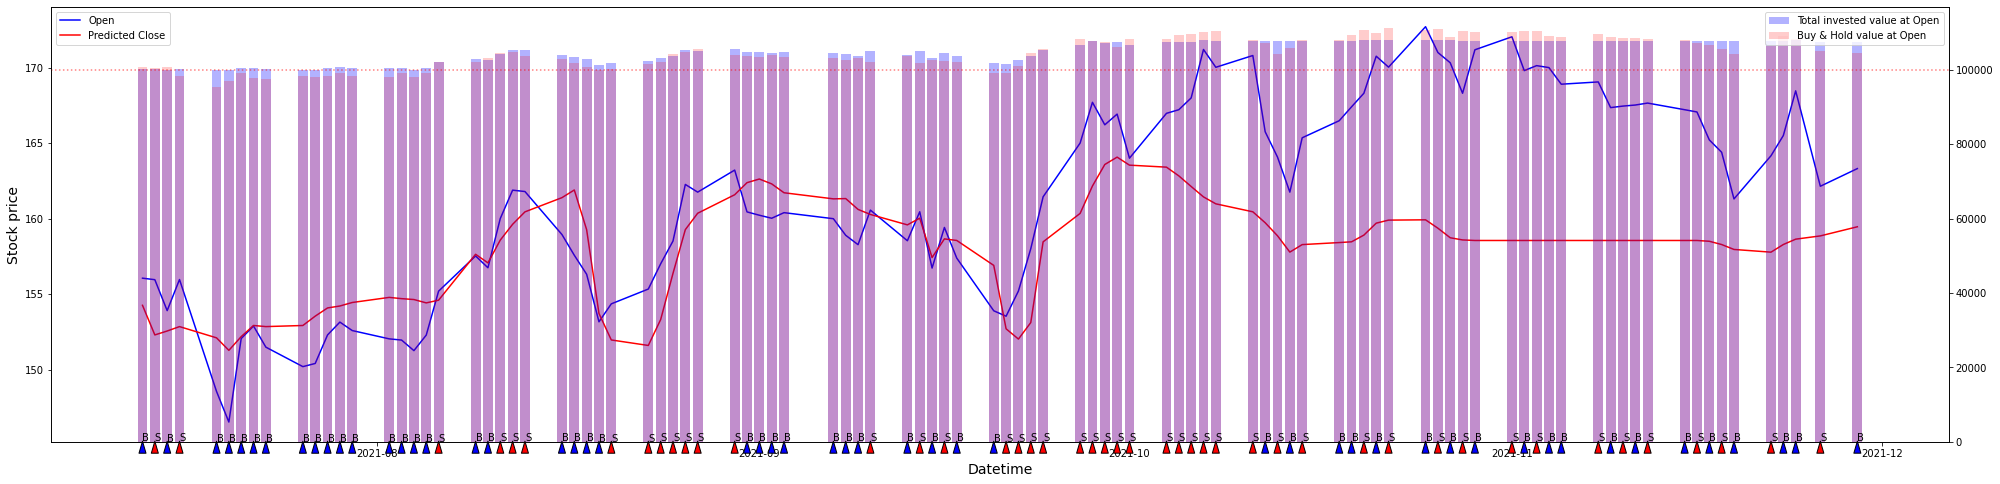

Trading Total(Profit%):  7.536423603428819 Trading Total:  107536.42360342882
Buy & Hold(Profit %): 4.457395109793084 Buy & Hold Total 104457.39510979308


In [46]:
plot_returns(plot_df)
print('Trading Total(Profit%): ',(plot_df.iloc[len(plot_df)-1]['Total']-100000)*100/100000,'Trading Total: ',plot_df.iloc[len(plot_df)-1]['Total'])
print('Buy & Hold(Profit %):',(plot_df.iloc[len(plot_df)-1]['Buy&Hold']-100000)*100/100000,'Buy & Hold Total',plot_df.iloc[len(plot_df)-1]['Buy&Hold'])